# Sparkify Project

# 1. Overview

To begin, we must define the project's goal and comprehend our business context. All of the decisions made in the following steps are consistent with our objectives.

Sparkify is a music streaming service. Many users use the Sparkify service on a daily basis, either using the free tier, which includes advertisements in between songs, or the premium subscription model, in which they stream music for free but pay a monthly flat rate. Users have the option to upgrade, downgrade, or cancel their service at any time. 

Whatever the size of your company or your operational model, if you sell products or services, the problem is the same in almost every industry – customer retention analysis. Keeping your current customers with the company for as long as possible can be difficult. To keep your customers satisfied over time, you must understand their needs, provide excellent customer service, and understand why they would leave your company.

When you have this knowledge, you can significantly improve your retention rate and overall performance. One of the keys to preventing customer churn is to gather as much information about them as possible. That is the starting point, which is also required for machine learning predicting systems, which will assist you with the process of predicting customer churn.

## 1.1. Problem Statement

We have a JSON log of all actions taken by Sparkify users over a two-month period; our goal is to learn from this dataset which behaviors can help us predict whether users will "churn" (i.e. unsubscribe from the service). To accomplish this, we will extract the most relevant features from the log and train a machine learning classifier; in this article, we will work with a small subset, representing 1% of the total size, but we will use the Spark framework and keep scalability in mind, to ensure the same code can be reused when using the full dataset, which is 12GB in size.

This is a `Customer Churn Prediction Problem` , there are so many similar projects, such as [WSDM - KKBox's Churn Prediction Challenge](https://www.kaggle.com/c/kkbox-churn-prediction-challenge) competition from [Kaggle](https://www.kaggle.com).

As a result, our job is to mine the customers' data and implement an appropriate model to predict customer churn in the following steps:

- Clean up the data: Analyze the NaN values, check the data types, and remove duplicates.
- EDA: Exploratory data analysis to examine feature distributions and correlations with key labels (churn).
- Feature engineering: Identifying and extracting customer features and customer behavior features to be considered in our model
- Train and measure models: I used Gradient Boost Tree classifier, Logistic Regression classifier, and Random Forest classifiers to train a baseline model and tune a better model from the best of them. It is worth noting that this data is unbalanced due to lower churn rates, so I chose 'f1 score' as a metric to assess model performance.


In [1]:
# Initialization libraries for Pyspark
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession

In [2]:
# Create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify Project") \
    .getOrCreate()

In [3]:
# Let's check if the change went through
spark.sparkContext.getConf().getAll()

[('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.app.id', 'local-1642718310447'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.driver.port', '38611'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.host', 'aa2c44af61f3'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.name', 'Sparkify Project')]

In [4]:
# display Spark version info
spark

In [5]:
# Data wrangling libraries
from pyspark.sql import SparkSession

from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, \
                                  avg, to_timestamp, from_unixtime, split, min, max, lit, mean
from pyspark.sql.functions import to_date, year, month, dayofmonth, dayofweek, hour, date_format, substring
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import abs as Fabs
from pyspark.sql.functions import round as Fround
from pyspark.sql.functions import row_number

from pyspark.sql.window import Window

from pyspark.sql.types import IntegerType
from pyspark.sql.types import StringType
from pyspark.sql.types import TimestampType

import datetime
import math
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

# 2. Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [6]:
# Import user log from json file
path = "mini_sparkify_event_data.json"
user_log = spark.read.json(path)

In [7]:
# View the first user log
user_log.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

In [8]:
# Let's print the schema of the dataset
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



First, we'll create a temporary view against which SQL queries can be run.

* _Note:This command should be run if you are working with declarative programming (SQL), but it is not required if you are working with imperative programming_.

In [9]:
# Creating a view
user_log.createOrReplaceTempView("user_log_table")

In [10]:
# Check if the view is working
spark.sql('''
          SELECT * 
          FROM user_log_table 
          LIMIT 2
          '''
          ).show()

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000|        8|   Canada|   200|1538352180000|"Moz

In [11]:
# Counting how many rows the dataset has
spark.sql('''
          SELECT COUNT(*) 
          FROM user_log_table 
          '''
          ).show()

+--------+
|count(1)|
+--------+
|  286500|
+--------+



## 2.1. Verify the fields and the data types

In this project, we will use a combination of imperative programming (not SQL) and declarative programming (SQL) depending on which is easier to use.

In [12]:
# show dataset fields
spark.sql("DESC user_log_table").show()

+-------------+---------+-------+
|     col_name|data_type|comment|
+-------------+---------+-------+
|       artist|   string|   null|
|         auth|   string|   null|
|    firstName|   string|   null|
|       gender|   string|   null|
|itemInSession|   bigint|   null|
|     lastName|   string|   null|
|       length|   double|   null|
|        level|   string|   null|
|     location|   string|   null|
|       method|   string|   null|
|         page|   string|   null|
| registration|   bigint|   null|
|    sessionId|   bigint|   null|
|         song|   string|   null|
|       status|   bigint|   null|
|           ts|   bigint|   null|
|    userAgent|   string|   null|
|       userId|   string|   null|
+-------------+---------+-------+



In [13]:
def unique(data, column):
    """
    Description:
        Return the unique values for a given column in the data set, 
        along with the row count.
    
    Args:
        data (DataFrame): a dataset. 
        column (str): a target column.

    Returns:
        DataFrame: A dataframe query that is sorted descendingly by count.
    """
    return data.groupby(column).count().sort(desc('count'))

FirstName and lastName are two columns that are insignificant to our analysis. We already have a user's unique identifier - userId - so these two columns add no new information to our analysis that isn't already in the userId attribute.

In [14]:
# Remove any unnecessary columns
user_log = user_log.drop('firstName')
user_log = user_log.drop('lastName')

In [15]:
unique(user_log, 'auth').show()

+----------+------+
|      auth| count|
+----------+------+
| Logged In|278102|
|Logged Out|  8249|
|     Guest|    97|
| Cancelled|    52|
+----------+------+



In [16]:
unique(user_log, 'gender').show()

+------+------+
|gender| count|
+------+------+
|     F|154578|
|     M|123576|
|  null|  8346|
+------+------+



In [17]:
unique(user_log, 'level').show()

+-----+------+
|level| count|
+-----+------+
| paid|228162|
| free| 58338|
+-----+------+



In [18]:
unique(user_log, 'page').show(30, False)

+-------------------------+------+
|page                     |count |
+-------------------------+------+
|NextSong                 |228108|
|Home                     |14457 |
|Thumbs Up                |12551 |
|Add to Playlist          |6526  |
|Add Friend               |4277  |
|Roll Advert              |3933  |
|Login                    |3241  |
|Logout                   |3226  |
|Thumbs Down              |2546  |
|Downgrade                |2055  |
|Help                     |1726  |
|Settings                 |1514  |
|About                    |924   |
|Upgrade                  |499   |
|Save Settings            |310   |
|Error                    |258   |
|Submit Upgrade           |159   |
|Submit Downgrade         |63    |
|Cancel                   |52    |
|Cancellation Confirmation|52    |
|Register                 |18    |
|Submit Registration      |5     |
+-------------------------+------+



In [19]:
unique(user_log, 'song').show(15, False)

+-------------------------------------------------------------------+-----+
|song                                                               |count|
+-------------------------------------------------------------------+-----+
|null                                                               |58392|
|You're The One                                                     |1153 |
|Undo                                                               |1026 |
|Revelry                                                            |854  |
|Sehr kosmisch                                                      |728  |
|Horn Concerto No. 4 in E flat K495: II. Romance (Andante cantabile)|641  |
|Dog Days Are Over (Radio Edit)                                     |574  |
|Secrets                                                            |466  |
|Use Somebody                                                       |459  |
|Canada                                                             |435  |
|Invalid    

In [20]:
unique(user_log, 'status').show(5, False)

+------+------+
|status|count |
+------+------+
|200   |259812|
|307   |26430 |
|404   |258   |
+------+------+



Two fields that must be transformed are registration and ts. They both save a timestamp. We can also use these two fields to add time-based features to our model. We can start by converting the ts and registration columns to timestamp columns.

In [21]:
# Convert timestamp
user_log = user_log.withColumn('tsDate', (col('ts') / 1000.0).cast(TimestampType()))
user_log = user_log.withColumn('date', to_date('tsDate'))
user_log = user_log.withColumn('registrationtsDate', (col('registration') / 1000.0).cast(TimestampType()))
user_log = user_log.withColumn('registration_date', to_date('registrationtsDate'))

user_log.createOrReplaceTempView("user_log_table")
user_log.take(1)

[Row(artist='Martha Tilston', auth='Logged In', gender='M', itemInSession=50, length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', tsDate=datetime.datetime(2018, 10, 1, 0, 1, 57), date=datetime.date(2018, 10, 1), registrationtsDate=datetime.datetime(2018, 9, 28, 22, 22, 42), registration_date=datetime.date(2018, 9, 28))]

In [22]:
spark.sql("DESC user_log_table").show()

+------------------+---------+-------+
|          col_name|data_type|comment|
+------------------+---------+-------+
|            artist|   string|   null|
|              auth|   string|   null|
|            gender|   string|   null|
|     itemInSession|   bigint|   null|
|            length|   double|   null|
|             level|   string|   null|
|          location|   string|   null|
|            method|   string|   null|
|              page|   string|   null|
|      registration|   bigint|   null|
|         sessionId|   bigint|   null|
|              song|   string|   null|
|            status|   bigint|   null|
|                ts|   bigint|   null|
|         userAgent|   string|   null|
|            userId|   string|   null|
|            tsDate|timestamp|   null|
|              date|     date|   null|
|registrationtsDate|timestamp|   null|
| registration_date|     date|   null|
+------------------+---------+-------+



Place and state are included in the location column. Let's divide the composed data into two features and remove the original column.

In [23]:
user_log = user_log.withColumn('city', split(user_log['location'], ',')[0])
user_log = user_log.withColumn('state', split(user_log['location'], ',')[1])
user_log = user_log.drop('location')

In [24]:
# After cleaning, show the dataset Schema
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- tsDate: timestamp (nullable = true)
 |-- date: date (nullable = true)
 |-- registrationtsDate: timestamp (nullable = true)
 |-- registration_date: date (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)



## 2.2. Dealing with missing entries

In [25]:
# Check for rows with missing values
user_log_valid = user_log.dropna(how = "any", subset = ["userId", "sessionId"])

In [26]:
# Counting the number of rows in the dataset
user_log_valid.count()

286500

Aside from the fact that we have no NaN values recorded, it is possible that we found blank records in these dataset attributes. So, let's take a look.

In [27]:
# Checking for records that are blank
user_log.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



As you can see, neither the userID nor the session columns have any missing values. However, some userID values are empty strings (user ids are recorded as `''`).

In [28]:
def filter_missing(data, column):
    """
    Description:
        Rows with missing values for a given column are returned, where a missing 
        value is either null or an empty string.
    
    Args:
        data (DataFrame): a dataset.
        column (str): a target column.    
        
    Returns:
        DataFrame: A dataframe query that contains missing values.
    """
    
    return data.where((col(column).isNull()) | (col(column) == ''))

def show_missing(data):
    """
    Description:
        Displays the number of missing values for each column in a given dataset.
    
    Args:
        data (DataFrame): a dataset.
        
    Returns:
        None
    """
    
    for field in data.schema:
        print(f'{field.name}: {filter_missing(data, field.name).count()}')

In [29]:
show_missing(user_log)

artist: 58392
auth: 0
gender: 8346
itemInSession: 0
length: 58392
level: 0
method: 0
page: 0
registration: 8346
sessionId: 0
song: 58392
status: 0
ts: 0
userAgent: 8346
userId: 8346
tsDate: 0
date: 0
registrationtsDate: 8346
registration_date: 8346
city: 8346
state: 8346


Let's see if the 8346 missing values in the user-related columns (firstName, gender, lastName, location, registration, userAgent, userId) belong to the same rows:

In [30]:
class Missing:
    """
    Description:
        A helper class for filtering out missing values.  
    
    Attributes:
        missing_data: a dataframe query created by the filter missing function.   
    """
    missing_data = None
    
    def __init__(self, data):
        self.missing_data = data
        
    def filter_missing(self, name):
        """
        Description:
            A method for filtering out missing values.
        
        Args:
            name (str): a column to filter.
            
        Returns:
            DataFrame: A dataframe query with missing values.
        """
        self.missing_data = filter_missing(self.missing_data, name) 
        return self  

In [31]:
m = Missing(user_log) \
    .filter_missing('userId') \
    .filter_missing('firstName') \
    .filter_missing('lastName') \
    .filter_missing('gender') \
    .filter_missing('location') \
    .filter_missing('registration') \
    .filter_missing('userAgent')
print(f'Missing count: {m.missing_data.count()}')

Missing count: 8346


We can conclude that missing values occur in the same rows because the filtering criterion contains the logical conjunction of all user-related columns and the count result of missing values is the same as when a single user-related column is filtered. This behavior is consistent with the logic that states that if a user identifier is missing, then all related user attributes should be missing as well.

We should take a moment now to consider these cases. What caused them to happen? The sparkify system is in perfect working order. What type of user lacks certain attributes?

In [32]:
filter_missing(user_log, 'userId').select('auth').dropDuplicates().show()

+----------+
|      auth|
+----------+
|Logged Out|
|     Guest|
+----------+



In [33]:
filter_missing(user_log, 'userId').select('page').dropDuplicates().show()

+-------------------+
|               page|
+-------------------+
|               Home|
|              About|
|Submit Registration|
|              Login|
|           Register|
|               Help|
|              Error|
+-------------------+



These logs most likely represent unregistered users or accesses to the sparkify site without a login. Then, because our target is a churned user who is also a registered user, it is obvious that removing the rows with missing users will not remove any churned users. Given the structure of the dataset and the nature of the analysis, logs lacking a SessionID or UserID are useless to us.

In [34]:
# Rows with missing users should be removed
user_log_valid = user_log.where(~((col('userId').isNull()) | (col('userId') == '')))
show_missing(user_log_valid) 

artist: 50046
auth: 0
gender: 0
itemInSession: 0
length: 50046
level: 0
method: 0
page: 0
registration: 0
sessionId: 0
song: 50046
status: 0
ts: 0
userAgent: 0
userId: 0
tsDate: 0
date: 0
registrationtsDate: 0
registration_date: 0
city: 0
state: 0


## 2.3. Duplicates

In [35]:
# Are there any duplicate rows?
print(f'Duplicate rows: {user_log_valid.count() - user_log_valid.dropDuplicates().count()}')

Duplicate rows: 0


# 3. Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

## 3.1. Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model.

* What exactly is customer churn in the business context? Explanation: Customer churn is the process by which customers discontinue using a company's products or services.

* Based on the dataset, we have the same understanding as presented above. The suggestion of using the Cancellation Confirmation events to define your churn, which occurs for both paid and free users, appears to be very reasonable because sparkify can profit from free users as well.

As a result, churn is the number of customers who have unsubscribed or canceled their service contract. Actually, it is very expensive to win back lost clients, not to mention that they will not do the best word-of-mouth marketing if they are dissatisfied.

_The following sections of the project were based on Amos Voron's analysis, which can be found at https://github.com/amosvoron/sparkify. In my opinion, he did an excellent job, and by reading his work, I was able to gain new ideas and insights into the problem and dataset. I learned a lot and used my own ideas and code to improve on what he had already done. This is supported by the results obtained at the end of this notebook._

**Again, I changed a lot of things here because I didn't agree with some procedures, approaches, and analyses, particularly in the sections on feature engineering and modeling.**

## 3.2. Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [36]:
def get_categories(data, column):
    """
    Description:
        This function generates a list of column categories.
    
    Args:
        data (DataFrame): a dataset. 
        column (str): a target column.

    Returns:
        list: a list of column categories. 
    """   
    return [str(row[column]) for row in unique(data, column).collect()]

### 3.2.1. Preliminary Analysis

In [37]:
# The number of unique users
user_log_valid.select('userId').dropDuplicates().count()

225

In [38]:
# The number of unique sessions
user_log_valid.select('sessionId').dropDuplicates().count()

2312

In [39]:
# Total time under observation
user_log.select(to_date(min('tsDate')).alias('MinDate'), to_date(max('tsDate')).alias('MaxDate')).show()

+----------+----------+
|   MinDate|   MaxDate|
+----------+----------+
|2018-10-01|2018-12-03|
+----------+----------+



In our mini dataset, we have 225 users. Their logs comprise nearly two months, from 2018-10-01 to 2018-12-03.

### 3.2.2. Log Level Analysis

The log level includes all of the rows in our dataset that are associated with the information level.

In [40]:
import seaborn as sb
import matplotlib
from matplotlib import gridspec

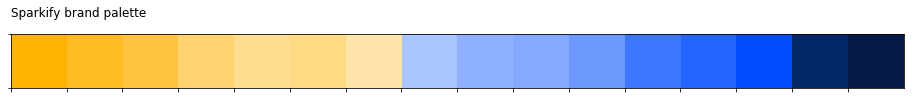

In [41]:
# An array of the company's brand colors
colors = ['#FEB201','#FFBC22','#FFC43D','#FFD36D','#FFDD8F','#FFDA85','#FFE5AA', \
         '#AAC4FF','#8FB1FF','#85A9FF','#6D99FF','#3D77FF','#2265FF','#014DFE', \
         '#042867', '#031A44']

# Sparkify Company's custom color palette
sparkify_palette = sb.set_palette(sb.color_palette(colors));

# Colors from the Sparkify Palette should be plotted
plt.figure(figsize=(12, 8), dpi=600)
sb.palplot(colors)
plt.title("Sparkify brand palette ", loc='left', y=1.2)

plt.show()

# Create a Colormap
sparkify_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors);

#### 3.2.2.1. Level and status

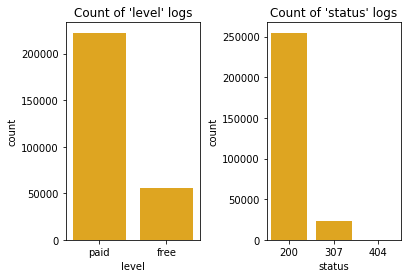

In [42]:
plt.subplots_adjust(wspace=0.5)

# Count log events based on the level attribute (paid, free)
df = user_log_valid.select('level').toPandas()
plt.subplot(1, 2, 1)
sb.countplot(data = df, x = 'level', color='#FEB201');
ax = plt.gca()
ax.set_title("Count of 'level' logs");

# Count log events according to status categories
df = user_log_valid.select('status').toPandas()
plt.subplot(1, 2, 2)
sb.countplot(data = df, x = 'status', color='#FEB201');
ax = plt.gca()
ax.set_title("Count of 'status' logs");

We have more logs from paid users than from free users. We almost never see 404 status messages in our logs, which can be interpreted positively given that this code represents a connection error.

#### 3.2.2.2. Page

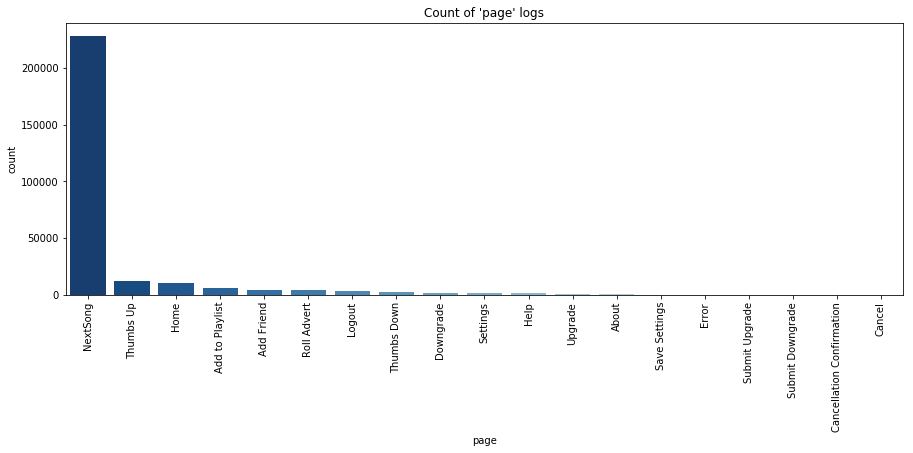

In [43]:
plt.figure(figsize = [15, 5])

df = user_log_valid.select('page').toPandas()
sb.countplot(data = df, x = 'page', order = df['page'].value_counts().index, palette = 'Blues_r');
plt.xticks(rotation = 90);
ax = plt.gca()
ax.set_title("Count of 'page' logs");

The page with the most visits was 'NextSong.' Something that is simple to explain given the nature of our dataset and business context.

#### 3.2.2.3. Gender

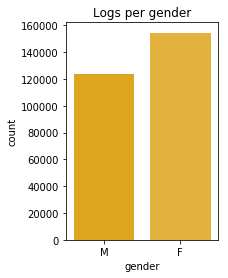

In [44]:
# Count the logs by gender
df_gender_logs = user_log_valid.select('gender').toPandas()
plt.subplot(1, 2, 1)
sb.countplot(data = df_gender_logs, x = 'gender', order = ['M','F'], palette = sparkify_palette).set_title('Logs per gender');

We have more logs from female users than male users, according to the graph. This is an intriguing result because, as shown in the graph below, the number of female users is lower than the number of male users. Perhaps women are more likely than men to listen to more songs on Sparkify.

### 3.2.3. User Level Analysis

A user level is a level at which data is aggregated based on the userId. We've already encountered the user-related columns that are userId-dependent, as their value does not change if a log event changes unless the userId attribute changes.

#### 3.2.3.1. Gender

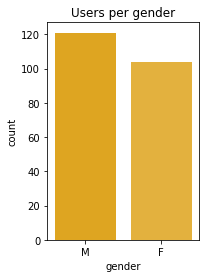

In [45]:
# Count the number of users by gender.
df_gender_users = user_log_valid.groupby('userId', 'gender').count().toPandas()
plt.subplot(1, 2, 2)
sb.countplot(data = df_gender_users, x = 'gender', order = ['M','F'], palette = sparkify_palette).set_title('Users per gender');

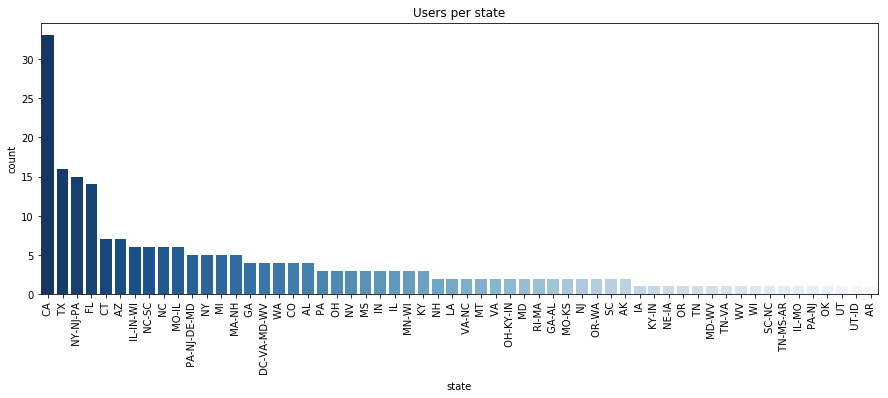

In [46]:
plt.figure(figsize = [15,5])

# Count the number of users by state.
df_user_state = user_log_valid.select('userId', 'state').dropDuplicates().toPandas()

data_order = df_user_state['state'].value_counts().index
sb.countplot(data = df_user_state, x = 'state', order = data_order, palette = 'Blues_r').set_title('Users per state')
plt.xticks(rotation = 90);
plt.show()

#### 3.2.3.2. Logs per user

In [47]:
def plot_hist_with_boxplot(df, column, title, bins=15, ):
    """Plots a histogram with boxplot.
    
    Args:
        df (pandas DataFrame): The data set.
        column (str): The name of a target column.  
        title (str): The title of a plot.
        bins (int, optional): The number of histogram's bins.
        
    Returns:
        None
    """
    
    # Statistics 
    print(df.describe())
    
    fig = plt.figure(figsize = [10, 4]);
    spec = gridspec.GridSpec(ncols=2, nrows=1,
                         width_ratios=[5, 1])
    plt.subplots_adjust(hspace=0.3)

    # Plot a histogram with a boxplot.
    ax0 = fig.add_subplot(spec[0])
    ax0.hist(df[column], bins=15, color='orange')
    ax0.set_title(title);
    plt.xlabel(column)
    plt.ylabel('frequency')
    ax1 = fig.add_subplot(spec[1])
    ax1.boxplot(df[column])

    plt.show()

             count
count   225.000000
mean   1236.240000
std    1329.531716
min       6.000000
25%     296.000000
50%     848.000000
75%    1863.000000
max    9632.000000


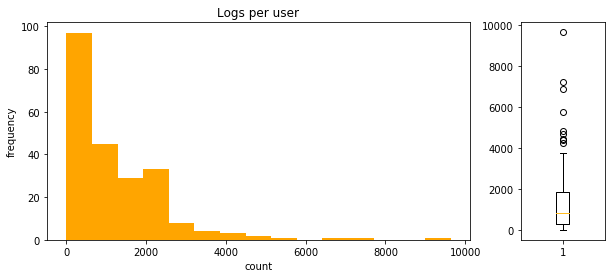

In [48]:
df_user_logs = user_log_valid.groupby('userId').count().toPandas()
plot_hist_with_boxplot(df_user_logs, 'count', 'Logs per user')

The log distribution per user is skewed to the right. There are a few extreme outliers that can be found. We can expect these outliers to have a negative impact on our statistical model in general. Regardless, no matter how much you want to, dismissing an observation simply because it is an outlier is not acceptable. They can be valid observations, and they can be the most interesting at times. It is critical to investigate the nature of the outlier before making a decision.

### 3.2.4. Session level

A session level aggregates data based on the userId and sessionId. It is important to note that the sessionId attribute is not a unique identifier of a session; it is unique only for a single user, and thus cannot be used in a cross-user context.

#### 3.2.4.1. Sessions per user

            count
count  225.000000
mean    14.115556
std     14.646885
min      1.000000
25%      6.000000
50%     10.000000
75%     18.000000
max    107.000000


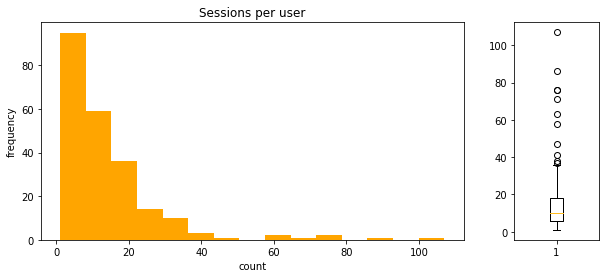

In [49]:
df_user_sessions = user_log_valid.select('userId', 'sessionId').dropDuplicates().groupby('userId').count().toPandas()
plot_hist_with_boxplot(df_user_sessions, 'count', 'Sessions per user')

The distribution of sessions per user is right-skewed, as is the distribution of logs per user.

#### 3.2.4.2. Session Duration

          duration
count  3176.000000
mean    299.518755
std     390.281555
min       0.000000
25%      58.129167
50%     160.541667
75%     381.283333
max    4455.083333


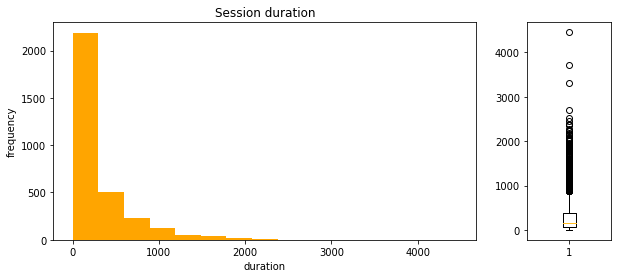

In [50]:
df_session_duration = user_log_valid.groupby('userId', 'sessionId') \
    .agg(((max('ts') - min('ts'))/60000).alias('duration')) \
    .select('duration').toPandas()
plot_hist_with_boxplot(df_session_duration, 'duration', 'Session duration')

The distribution of sessions duration is right-skewed, as is the distribution of logs per user.

I decided to keep the outliers because they are not an error. They represent user behaviors that can occur in real life. As a result, they capture valuable information that is relevant to your business.

### 3.2.5. Churn Definition and Analysis

I will focus on the first type, the cancelled users, as suggested by Udacity.

In [51]:
# Check the number of users who have been cancelled
cancelled = user_log_valid.where(user_log_valid.page == 'Cancellation Confirmation').select('userId').dropDuplicates()
cancelled.count()

52

In [52]:
def get_users(churn):
    """
    Description:
        Returns a list of unique users from a given churn group.
    
    Args:
        churn (int): The churn column, which contains Boolean values (0 - non-churned, 1 - churned).
        
    Returns:
        DataFrame: A dataframe query.
    """
    return user_log_valid.where(user_log_valid.churn == churn).select('userId').dropDuplicates()

I'll assign a 1 to churned users and a 0 to non-churned users. Likewise, variables with the suffix "1" represent churned users, while variables with the suffix "0" represent non-churned users.

In [53]:
# Label churned (canceled) users
cancelled_uids = [row.userId for row in cancelled.collect()];
set_churn = udf(lambda x: 1 if x in cancelled_uids else 0, IntegerType())
user_log_valid = user_log_valid.withColumn('churn', set_churn('userId'))

print(f"Churned users who cancelled subscription: {get_users(1).count()}")

Churned users who cancelled subscription: 52


In [54]:
# Add a [userRowId] column that assigns a 1-based index to each user's log in the order specified by [ts].
w =  Window.partitionBy(user_log_valid.userId).orderBy('ts', 'itemInSession')
user_log_valid = user_log_valid.withColumn('userRowId', row_number().over(w))

# Visualize the user_log_valid
user_log_valid.select(["userId", "level", "page", "song", 'itemInSession', 'userRowId']).where(user_log.userId == "100010").show(10)

+------+-----+-----------+--------------------+-------------+---------+
|userId|level|       page|                song|itemInSession|userRowId|
+------+-----+-----------+--------------------+-------------+---------+
|100010| free|   NextSong|Captain Tyin Knot...|            0|        1|
|100010| free|   NextSong|Beautiful_ Beauti...|            1|        2|
|100010| free|   NextSong|          She's Gone|            2|        3|
|100010| free|  Thumbs Up|                null|            3|        4|
|100010| free|   NextSong|      Folk Bloodbath|            4|        5|
|100010| free|   NextSong|                 Yes|            5|        6|
|100010| free|   NextSong|             Secrets|            6|        7|
|100010| free|   NextSong|      You're The One|            7|        8|
|100010| free|Roll Advert|                null|            8|        9|
|100010| free|   NextSong|          Mr Sandman|            9|       10|
+------+-----+-----------+--------------------+-------------+---

In [55]:
# Add [userRowDescId] column that assigns a 1-based index to each user's log in the order specified by [ts] descending.
w =  Window.partitionBy(user_log_valid.userId).orderBy(col('ts').desc(), col('itemInSession').desc())
user_log_valid = user_log_valid.withColumn('userRowDescId', row_number().over(w))

# Visualize the results
user_log_valid.select(["userId", "level", "page", "song", 'itemInSession', 'userRowId', 'userRowDescId']).where(user_log.userId == "100010").show(10)

+------+-----+-----------+-------------------+-------------+---------+-------------+
|userId|level|       page|               song|itemInSession|userRowId|userRowDescId|
+------+-----+-----------+-------------------+-------------+---------+-------------+
|100010| free|     Logout|               null|           34|      381|            1|
|100010| free|   NextSong|                 22|           33|      380|            2|
|100010| free|   NextSong|        Missing You|           32|      379|            3|
|100010| free|   NextSong|Letters From Madrid|           31|      378|            4|
|100010| free|Roll Advert|               null|           30|      377|            5|
|100010| free|   NextSong|         Alley Cats|           29|      376|            6|
|100010| free|   NextSong|     Taking My Ball|           28|      375|            7|
|100010| free|   NextSong|Walking On The Moon|           27|      374|            8|
|100010| free|   NextSong|        Kiss N Tell|           26|     

In [56]:
# Visualize an example that has cancelled
user_log_valid.select(["userId", "level", "page", "song", 'itemInSession', 'userRowId', 'userRowDescId']).where(user_log.userId == "100012").show(10)

+------+-----+--------------------+--------------------+-------------+---------+-------------+
|userId|level|                page|                song|itemInSession|userRowId|userRowDescId|
+------+-----+--------------------+--------------------+-------------+---------+-------------+
|100012| free|Cancellation Conf...|                null|           74|      600|            1|
|100012| free|              Cancel|                null|           73|      599|            2|
|100012| free|         Roll Advert|                null|           72|      598|            3|
|100012| free|            NextSong|           The Piano|           71|      597|            4|
|100012| free|         Thumbs Down|                null|           70|      596|            5|
|100012| free|            NextSong|           Parachute|           69|      595|            6|
|100012| free|            NextSong|Glamorous Indie R...|           68|      594|            7|
|100012| free|            NextSong|   Where Is My 

In [57]:
# Add lastLevel column
last_levels = dict()
for row in user_log_valid.where(user_log_valid.userRowDescId == 1).select('userId', 'level').collect():
    last_levels[row.userId] = row.level
get_level = udf(lambda userId: last_levels[userId])
user_log_valid = user_log_valid.withColumn('lastLevel', get_level('userId'))

# Visualize an example that has cancelled
user_log_valid.select(["userId", "level", "page", "song", 'itemInSession', 'userRowId', 'userRowDescId', 'lastLevel']).where(user_log.userId == "100012").show(10)

+------+-----+--------------------+--------------------+-------------+---------+-------------+---------+
|userId|level|                page|                song|itemInSession|userRowId|userRowDescId|lastLevel|
+------+-----+--------------------+--------------------+-------------+---------+-------------+---------+
|100012| free|Cancellation Conf...|                null|           74|      600|            1|     free|
|100012| free|              Cancel|                null|           73|      599|            2|     free|
|100012| free|         Roll Advert|                null|           72|      598|            3|     free|
|100012| free|            NextSong|           The Piano|           71|      597|            4|     free|
|100012| free|         Thumbs Down|                null|           70|      596|            5|     free|
|100012| free|            NextSong|           Parachute|           69|      595|            6|     free|
|100012| free|            NextSong|Glamorous Indie R...

Following the definition of churn, conduct some exploratory data analysis to compare the behavior of users who stayed versus users who left. To begin, look at aggregates for these two groups of users, noting how much of a specific action they performed per time unit or number of songs played.

_The project's General Statistical Method section was based on Amos Voron's explanation and code, which can be found at https://github.com/amosvoron/sparkify._

### 3.2.6. General statistical method
Let us now describe the *general statistical method* and its simple mathematics, which will be used in all exploratory analyses throughout the project.

A certain **feature** $f$ of a user $x$

> $f(x)$

can be important for our learning model only if it can serve us to "distinguish well" between the two churn groups (*churned*, *non-churned*). We use a certain *aggregation* (or **group**) function $g$ like *mean*

> $g(f, y)$  

where *y* is a **churn group** (1 or 0) to determine if the feature $f$ "distinguish well" between the two churn groups. The group function is applied over the subset of users that belong to a specified group *y*. If the absolute value of a difference between the aggregation values is "big enough"

> diff = $|g(f, 1) - g(f, 0)|$ 

we can say that the feature $f$ "distinguish well". However, in order to determine whether the value *diff* is "large enough," we must first normalize it. Let

> $g_1$ = $g(f, 1)$ 

and 

> $g_2$ = $g(f, 0)$

Then a **ratio** of *churned* users (for a given feature $f$) is:

> $r_1$ = $\frac{g_1}{g_1 + g_0}$  

Similarly, a *ratio* of *non-churned* users is

> $r_0$ = $\frac{g_0}{g_1 + g_0}$  

Now, let us calculate the difference ($\Delta$) between the both ratios:

> $\Delta$ = $r_1$ - $r_0$ = $\frac{g_1 - g_0}{g_1 + g_0}$ 

which gives us a **ratio difference** with absolute values between 0 and 1. Note that we do not express the ratio difference as an *absolute value* since we want to preserve the sign which will tell as, if **positive**, that the feature $f$ for a group of churned users gives, on average (if *g* is a *mean* function), *higher values* than the same feature $f$ for a group of non-churned users, and, if **negative**, it gives *lower values*.
   
##### Delta threshold
The idea behind using the *delta* as a deciding factor for feature selection is that a feature is important for our model if and only if it can distinguish "well enough" between the two churn groups. A  feature probably will work well for our learning model if the **delta threshold** is set to

> $|\Delta| > 0.15$

which means that there should be **at least 15% of difference** between the churn group ratios in order **to select the feature for our learning model**. 

It is essentially a statistical approach **applied over a single, isolated feature**; that is, we perform a simple one-dimensional calculation with one feature, whereas machine learning is far more complex, with it being extremely difficult to predict which features will serve best prior to model fitting.

##### Why we have to normalize?

Suppose that each user from both churn groups listen **1** song per day (*f-value*). In case of using the *user-based* $f$ function we calculate the churn average per day which would give us **1** at any date (since every user listens exactly **1** song per day). The graph would be a horizontal line since both lines would perfectly overlap. 

On the other side, the plain aggregation counts the total of song logs per each churn group. If there are 52 churned users and 173 non-churned, then the delta is

> $\Delta$ = $\frac{53-173}{225}$ = -0.54

which is close to **-0.68** of the plain aggregation. Matematically, we haven't *normalized* our observed values when we applied the plain aggregation. Since the weight of the *non-churned* group is higher due to having more members, this initial difference in weights between the both churn groups must be normalized by the proper preparation of *f-values* which is: 

> **The group function $g$ must always apply aggregation over the feature function $f$ which exposes f-values calculated *per user***. 

In [58]:
# Determine the delta threshold
delta_threshold = 0.15

# a list of churning groups (for bar plots)
churn_groups = ['churned', 'non-churned']

# List of churn groups in reverse order (for histogram plots)
churn_groups_reverse = ['non-churned', 'churned']

#### 3.2.6.1. Functions

Let us define the functions that will be used in our approach.

In [59]:
# Set plot's figure size
def set_plot_size(width, height):
    """
    Description: 
        Set the plot's figure size.
    
    Args:
        width (int): width of a figure.
        height (int): height of a figure.
        
    Returns:
        Figure: figure instance.
    """
    
    return plt.figure(figsize = [width, height]);

In [60]:
def has_attribute(df):
    """
    Description: 
        If the data set contains attribute, this function returns true.
    
    Args:
        df (DataFrame): a dataset.  
    
    Returns:
        bool: True if df contains an attribute, False otherwise.. 
    """
    
    return 'attribute' in df.columns

In [61]:
def get_attribute(data, attribute):
    """
    Description:
        Gets all distinct values of a given attribute.
    
    Args:
        data (DataFrame): a dataset.
        attribute (str): a attribute column name.
        
    Returns:
        attribute (str): a attribute column name 
        list: a list of all the distinct values of an attribute.
    """
    
    attr_dict = dict()
    attr_dict['column'] = attribute
    attr_dict['values'] = [row[attribute] for row in unique(data, attribute).collect()]
    
    return attr_dict

In [62]:
def get_g(f, agg_method='avg'):
    """
    Description:
        Returns the group function that aggregates the g-values of a feature per churn group. 
        The group function computes mean by default.
    
    Args:
        f (DataFrame): The dataframe for the feature function, which must include the following columns:
                           - userId: user identifier
                           - churn: 1-churned, 0-non-churned
                           - f-value: value of an observing feature
                           - attribute (optional): value of an attribute
        agg_method (str, optional): A g function's aggregation method. 'avg' is the default (mean).
        
    Returns:
        DataFrame: The output of the group function is as follows:
                       - churn: 1-churned, 0-non-churned
                       - g-value: value of a group function
                       - attribute (optional): value of an attribute column
    """
    
    if has_attribute(f) == True:
        return f \
            .groupby('churn', 'attribute') \
            .agg({'f-value': agg_method}) \
            .select('churn', 'attribute', col(f'{agg_method}(f-value)').alias('g-value')) \
            .sort('attribute', desc('churn'))
    else:
         return f \
            .groupby('churn') \
            .agg({'f-value': agg_method}) \
            .select('churn', col(f'{agg_method}(f-value)').alias('g-value')) \
            .sort(desc('churn'))

In [63]:
def calc_delta(g):
    """
    Description:
        Calculates a feature's ratios and delta. If an attribute is specified, the delta is 
        computed for each attribute value.
    
    Args:
        g (DataFrame): The group function that should include:
                         - churn: 1-churned, 0-non-churned users
                         - g-value: value of a group function
                         - attribute (optional): value of an attribute
        
    Returns:
        deltaset (DataFrame): The statistical dataset includes the following columns:
                                - churn: 1-churned, 0-non-churned
                                - g-value: result of a group function
                                - ratio: ratio of a feature
                                - delta: delta of a feature
                                - candidate: Is this a potential feature for the learning model?  
                                             (true if delta > delta_threshold; else false)
    """
    
    if has_attribute(g) == True:
        total = g.groupby('attribute').sum('g-value')
        deltaset = g \
            .join(total, g.attribute == total.attribute, 'inner') \
            .select(g['churn'], g['attribute'], g['g-value'], total['sum(g-value)']) \
            .withColumn('ratio', col('g-value')/col('sum(g-value)')) \
            .withColumn('delta', when(col('churn') == 1, 2 * (col('ratio') - 0.5)) \
                                 .otherwise(2 * (0.5 - col('ratio')))) \
            .withColumn('candidate', Fabs(col('delta')) > delta_threshold) \
            .drop('sum(g-value)') \
            .sort('attribute', desc('churn'))        
    else:   
        total = g.groupby().sum('g-value').first()['sum(g-value)']
        deltaset = g \
            .withColumn('ratio', col('g-value')/lit(total)) \
            .withColumn('delta', when(col('churn') == 1, 2 * (col('ratio') - 0.5)) \
                             .otherwise(2 * (0.5 - col('ratio')))) \
            .withColumn('candidate', Fabs(col('delta')) > delta_threshold) \
            .sort(desc('churn'))

    return deltaset

In [64]:
def plot_delta(deltaset, attr_dict=None, title='Analysis per churn group'
               , loc=1, width=None, height=None, rotation=0):
    """
    Description:
        The deltaset is plotted (bar plot).
    
    Args:
        deltaset (pandas DataFrame): The statistical data, including g-values, ratios, and delta. 
        attr_dict (dict, optional): The attribute dictionary with column and values keys.
        title (str): The plot's title.
        loc (int, optional): The location of the plot's legend.
        width (int, optional): The plot width.
        height (int, optional): The plot height.
        rotation (int, optional): The label rotation of the plot's legend.
        
    Returns:
        None
    """
    
    # Convert a deltaset to a pandas DataFrame and sort the values based on churn
    df = deltaset.toPandas().sort_values(by='churn', ascending=False)    
    w = 0.35
        
    if attr_dict == None:
        # Divide the dataset into two churn subsets
        df1 = df[df.churn == 1]
        df0 = df[df.churn == 0]
        
        # Default width, height
        if width == None:
            width = 4
            height = 4

        set_plot_size(width, height)       
        labels = churn_groups
        plt.xticks([], [])
        plt.xlabel('')       
        middle_line_factor = 0.3
    else:  
        # Divide the dataset into two churn subsets
        df1 = df[df.churn == 1].sort_values(by='attribute')
        df0 = df[df.churn == 0].sort_values(by='attribute')
    
        # Default width, height
        if width == None:
            width = 8
            height = 4
    
        set_plot_size(width, height)    
        labels = attr_dict['values']
        plt.xticks(range(len(labels)), df1['attribute'])
        plt.xlabel(attr_dict['column'])  
        middle_line_factor = 0.9
    
    plt.ylabel('ratio')
    plt.bar(np.arange(len(df1)), df1['ratio'], width=w, color='orange')
    plt.bar(np.arange(len(df0)) + w, df0['ratio'], width=w, color='#042867')
    plt.xticks(rotation=rotation);   
    ax = plt.gca()
    ax.set_title(title);    
    plt.legend(churn_groups, loc=loc) 
     
    # Make a mark on the middle line with delta threshold lines.
    plt.axhline(y=0.5, xmin=0, xmax=1, color='grey', linestyle=':', linewidth=1)
 
    plt.show()

In [1]:
def analyse(g, attr_dict=None, title='Analysis per churn group', loc=1, width=None, height=None, rotation=0):
    """
    Description: 
        Analyzes a given feature by calculating g-values, ratios, and delta and plotting the statistics.
    
    Args:
        g (DataFrame): The group function that should include:
                         - churn: 1-churned, 0-non-churned users
                         - g-value: value of a group function
                         - attribute (optional): value of an attribute
        attr_dict (dict, optional): The attribute dictionary with column and values keys.
        title (str): The plot's title.
        loc (int, optional): The location of the plot's legend.
        width (int, optional): The plot width.
        height (int, optional): The plot height.
        rotation (int, optional): The label rotation of the plot's legend.
        
    Returns:
        delta_df (pandas DataFrame): The statistical dataset includes the following columns:
                                         - churn: 1-churned, 0-non-churned
                                         - g-value: result of a group function
                                         - ratio: ratio of a feature
                                         - delta: delta of a feature
                                         - over_threshold: true if delta > delta_threshold; else false        
    """
    
    if has_attribute(g) == True:
        deltaset = calc_delta(g).select('churn', 'attribute' \
                                   , Fround('g-value', 6).alias('g-value') \
                                   , Fround('ratio', 6).alias('ratio') \
                                   , Fround('delta', 6).alias('delta') \
                                   , 'candidate') \
        
    else:
        deltaset = calc_delta(g).select('churn' \
                                   , Fround('g-value', 6).alias('g-value') \
                                   , Fround('ratio', 6).alias('ratio') \
                                   , Fround('delta', 6).alias('delta') \
                                   , 'candidate') \
        
    deltaset.show(100, False)
    plot_delta(deltaset, attr_dict, title, loc, width, height, rotation)
    return deltaset

In [66]:
def plot_hist(f, attr_dict=None, title=None, bins=15, width=15, height=3):
    """
    Description:
        Plots a histogram of f-values for each churn group.
    
    Args:
        f (DataFrame): The feature function dataframe which must contain the following columns:
                         - userId: user identifier
                         - churn: 1-churned, 0-non-churned
                         - f-value: value of an observing feature
                         - attribute (optional): value of an attribute
        attr_dict (dict, optional): The attribute dictionary with column and values keys.
        title (str, optional): The title of a histogram.
        bins (int, optional): The number of histogram's bins.
        width (int, optional): The plot width.
        height (int, optional): The plot height.
        
    Returns:
        None
    """
    # Convert df to a pandas DataFrame 
    df = f.toPandas()
    
    # Divide the dataset into two churn subsets
    df1 = df[df.churn == 1]
    df0 = df[df.churn == 0]
    column = 'f-value'
        
    fig = set_plot_size(width, height);
    
    # Plot a single histogram
    if attr_dict == None:
        spec = gridspec.GridSpec(ncols=1, nrows=1)
        ax = fig.add_subplot(spec[0])
        ax.hist(df0[column], bins=15, color='#042867')
        ax.hist(df1[column], bins=15, color='orange')       
        if title != None:
            ax.set_title(title);           
        plt.xlabel(column)
        plt.ylabel('frequency')
        plt.legend(churn_groups_reverse, loc=1) 
        plt.show()
        return
    
    # Plot multiple histograms, each for a unique value for each attribute.
    n_subplots = len(attr_dict['values'])
    ncols = 3
    nrows = math.ceil(n_subplots/ncols)   
    spec = gridspec.GridSpec(ncols=ncols, nrows=nrows, hspace=0.4)

    i = 0
    for value in attr_dict['values']:
        # Filter f-values by attribute
        df1_attr = df1[df1['attribute'] == value]
        df0_attr = df0[df0['attribute'] == value]

        ax = fig.add_subplot(spec[i])
        ax.hist(df0_attr[column], bins=15, color='#042867')
        ax.hist(df1_attr[column], bins=15, color='orange')
        ax.set_title(f'Log distribution of {attr_dict["column"]}={value}');
        plt.xlabel(column)
        plt.ylabel('frequency')    
        plt.legend(churn_groups_reverse, loc=1) 
        i += 1

    plt.show()

#### 3.2.6.2. Log Level Analysis

##### Log count
> - The feature function $f$ returns the **log count** per user. 
> - The group function $g$ returns the **average log count** per churn group.

+-----+----------+-------+---------+---------+
|churn|g-value   |ratio  |delta    |candidate|
+-----+----------+-------+---------+---------+
|1    |862.769231|0.39017|-0.219661|true     |
|0    |1348.49711|0.60983|-0.219661|true     |
+-----+----------+-------+---------+---------+



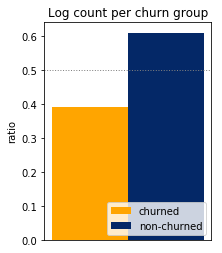

In [67]:
# Define and analyze the f function
f_LogCount = user_log_valid \
    .groupby('userId', 'churn') \
    .agg(count('userId').alias('f-value'))

# Obtain the g function
g = get_g(f_LogCount)

analyse(g, None, title='Log count per churn group', loc=4, width=3, height=4);

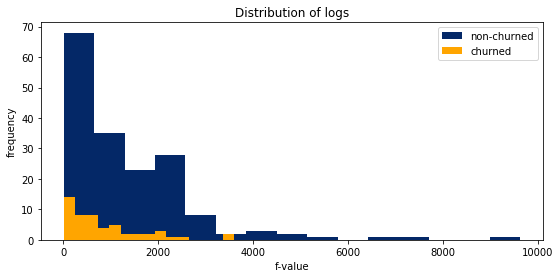

In [68]:
# Display the f-value distribution
plot_hist(f_LogCount, None, 'Distribution of logs', width=9, height=4)

##### Gender

*Log attribute count*
> - The feature function $f$ returns the **log attribute count** per user. 
> - The group function $g$ return the **average log attribute count** per churn group.

In [2]:
def get_f_LogAttributeCount(data, attribute):
    """
    Description:
        The feature function for log attribute count statistics is returned.
    
    Args:
        data (DataFrame): a dataset.
        attribute (str): a attribute column name.
        
    Returns:
        Dataframe: a dataframe query.
    """
    
    return data \
        .groupby('userId', 'churn', col(attribute).alias('attribute')) \
        .agg(count(attribute).alias('f-value'))

+-----+---------+-----------+--------+---------+---------+
|churn|attribute|g-value    |ratio   |delta    |candidate|
+-----+---------+-----------+--------+---------+---------+
|1    |F        |958.4      |0.372857|-0.254286|true     |
|0    |F        |1612.02381 |0.627143|-0.254286|true     |
|1    |M        |803.0      |0.422015|-0.15597 |true     |
|0    |M        |1099.775281|0.577985|-0.15597 |true     |
+-----+---------+-----------+--------+---------+---------+



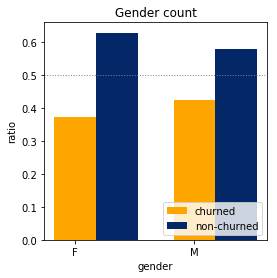

In [70]:
# Get f function by attribute and analyse it
f_GenderCount = get_f_LogAttributeCount(user_log_valid, 'gender')

# Get g function
g = get_g(f_GenderCount)

# Define attribute
attr_dict = get_attribute(user_log_valid, 'gender')

analyse(g, attr_dict=attr_dict, title='Gender count', loc=4, width=4, height=4);

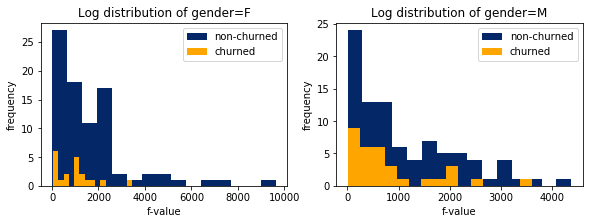

In [71]:
# Show distribution of f-values
plot_hist(f_GenderCount, attr_dict, 'Distribution of logs')

##### Method

+-----+---------+-----------+--------+---------+---------+
|churn|attribute|g-value    |ratio   |delta    |candidate|
+-----+---------+-----------+--------+---------+---------+
|1    |GET      |71.865385  |0.426827|-0.146346|false    |
|0    |GET      |96.505814  |0.573173|-0.146346|false    |
|1    |PUT      |790.903846 |0.387043|-0.225914|true     |
|0    |PUT      |1252.549133|0.612957|-0.225914|true     |
+-----+---------+-----------+--------+---------+---------+



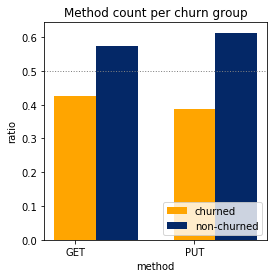

In [72]:
# Get f function by attribute and analyse it
f_MethodCount = get_f_LogAttributeCount(user_log_valid, 'method')

# Get g function
g = get_g(f_MethodCount)

# Define attribute
attr_dict = get_attribute(user_log_valid, 'method')

analyse(g, attr_dict=attr_dict, title='Method count per churn group', loc=4, width=4, height=4);

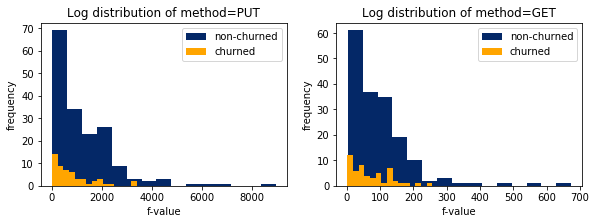

In [73]:
# Show distribution of f-values
plot_hist(f_MethodCount, attr_dict, 'Distribution of method logs', 'method')

##### Status

+-----+---------+-----------+--------+---------+---------+
|churn|attribute|g-value    |ratio   |delta    |candidate|
+-----+---------+-----------+--------+---------+---------+
|1    |200      |791.096154 |0.390536|-0.218928|true     |
|0    |200      |1234.572254|0.609464|-0.218928|true     |
|1    |307      |71.057692  |0.384037|-0.231927|true     |
|0    |307      |113.97076  |0.615963|-0.231927|true     |
|1    |404      |1.454545   |0.385787|-0.228426|true     |
|0    |404      |2.315789   |0.614213|-0.228426|true     |
+-----+---------+-----------+--------+---------+---------+



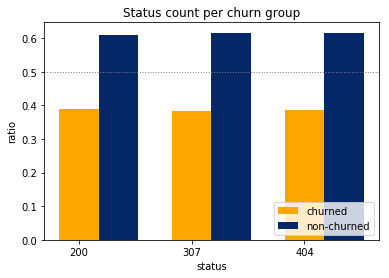

In [74]:
# Get f function by attribute and analyse it
f_StatusCount = get_f_LogAttributeCount(user_log_valid, 'status')

# Get g function
g = get_g(f_StatusCount)

# Define attribute
attr_dict = get_attribute(user_log_valid, 'status')

analyse(g, attr_dict=attr_dict, title='Status count per churn group', loc=4, width=6, height=4);

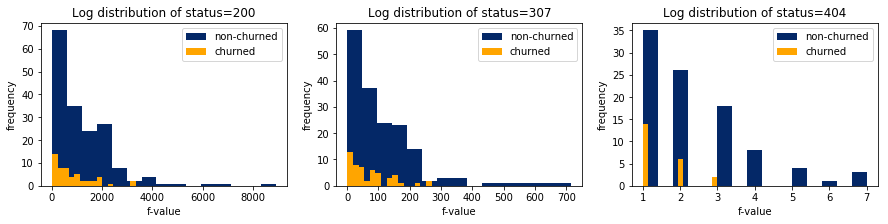

In [75]:
# Show distribution of f-values
plot_hist(f_StatusCount, attr_dict, 'Distribution of status logs', bins=15, width=15, height=3)

#### 3.2.6.3. User Level Analysis

In [76]:
# Get churn group count
count1 = get_users(1).count()
count0 = get_users(0).count()
count1, count0

(52, 173)

In [3]:
def get_f_UserAttribute(data, attribute):
    """
    Description:
        The feature function of a user attribute is returned.
    
    Args:
        data (DataFrame): a dataset.
        attribute (str): a attribute column name.
        
    Returns:
        f (DataFrame): feature function of a user attribute.
    """
    
    return data \
        .select('userId', 'churn', col(attribute).alias('attribute')) \
        .dropDuplicates() \
        .withColumn('f-value', lit(1)) # the user attribute has f-value of 1 (counts as 1)

def get_g_UserAttribute(f, attribute):
    """
    Description:
        The group function of a user attribute is returned.
    
    Args:
        data (DataFrame): a dataset.
        attribute (str): a attribute column name.
        
    Returns:
        g (DataFrame): feature function of a user attribute
    """
    
    return f \
        .withColumn('total', when(col('churn') == 1, count1).otherwise(count0)) \
        .groupby('churn', 'total', 'attribute') \
        .agg(Fsum('f-value')/col('total')) \
        .select('churn', 'total', 'attribute', col('(sum(f-value) / total)').alias('g-value')) \
        .sort('attribute', desc('churn'))

##### Gender
> - The feature function $f$ returns the **f-value of 1 per user**.
> - The group function $g$ returns the **gender ratio per churn**. 

+-----+---------+--------+--------+---------+---------+
|churn|attribute|g-value |ratio   |delta    |candidate|
+-----+---------+--------+--------+---------+---------+
|1    |F        |0.384615|0.442003|-0.115994|false    |
|0    |F        |0.485549|0.557997|-0.115994|false    |
|1    |M        |0.615385|0.544667|0.089335 |false    |
|0    |M        |0.514451|0.455333|0.089335 |false    |
+-----+---------+--------+--------+---------+---------+



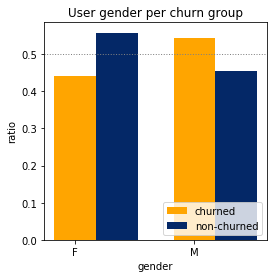

In [78]:
# Get f function
f_UserGender = get_f_UserAttribute(user_log_valid, 'gender')

# Get g function
g_UserGender = get_g_UserAttribute(f_UserGender, 'gender')

# Define attribute
attr_dict = get_attribute(user_log_valid, 'gender')

analyse(g_UserGender, attr_dict=attr_dict, title='User gender per churn group', loc=4, width=4, height=4);

##### Last level
> - The feature function $f$ returns the **f-value of 1 per user**.
> - The group function $g$ returns the **last level ratio per churn**.

+-----+---------+--------+--------+--------+---------+
|churn|attribute|g-value |ratio   |delta   |candidate|
+-----+---------+--------+--------+--------+---------+
|1    |free     |0.403846|0.542158|0.084316|false    |
|0    |free     |0.34104 |0.457842|0.084316|false    |
|1    |paid     |0.596154|0.47498 |-0.05004|false    |
|0    |paid     |0.65896 |0.52502 |-0.05004|false    |
+-----+---------+--------+--------+--------+---------+



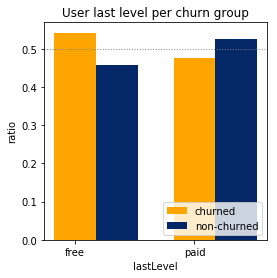

In [79]:
# Get f function
f_UserLastLevel = get_f_UserAttribute(user_log_valid, 'lastLevel')

# Get g function
g_UserLastLevel = get_g_UserAttribute(f_UserLastLevel, 'lastLevel')

# Define attribute
attr_dict = get_attribute(user_log_valid, 'lastLevel')

analyse(g_UserLastLevel, attr_dict=attr_dict, title='User last level per churn group', loc=4, width=4, height=4);

#### 3.2.6.4. Song Level Analysis

##### Song count
> - The feature function $f$ returns the **song count per user**.
> - The group function $g$ returns the **average song count per churn**.

+-----+----------+--------+---------+---------+
|churn|g-value   |ratio   |delta    |candidate|
+-----+----------+--------+---------+---------+
|1    |699.884615|0.387092|-0.225816|true     |
|0    |1108.17341|0.612908|-0.225816|true     |
+-----+----------+--------+---------+---------+



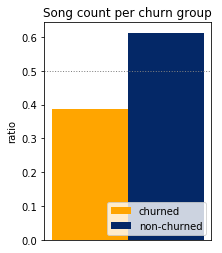

In [80]:
# Define f function - we are using the same function f that was used for the NextSong log page attribute. 
f_SongCount = get_f_LogAttributeCount(user_log_valid, 'page') \
    .where(col('attribute') == 'NextSong') \
    .select('userId', 'churn', 'f-value')

g_SongCount = get_g(f_SongCount)

analyse(g_SongCount, None, title='Song count per churn group', loc=4, width=3, height=4);

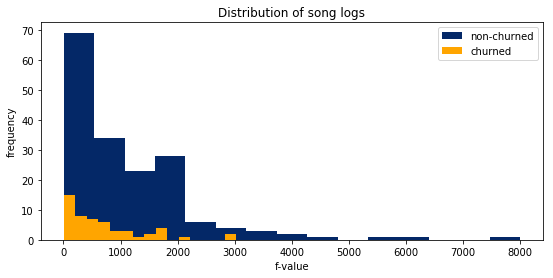

In [81]:
# Show distribution of f-values
plot_hist(f_SongCount, None, 'Distribution of song logs', bins=15, width=9, height=4)

In [82]:
# Observation period
user_log_valid.agg(min('date'), max('date')).show()

+----------+----------+
| min(date)| max(date)|
+----------+----------+
|2018-10-01|2018-12-03|
+----------+----------+



In [87]:
def plot_timeline(g, title, timeunit, rotation=0):
    """
    Description:
        Plots a line graph of a time series.
    
    Args:
        g (DataFrame): The group function.
        title (str): The plot's title.
        timeunit (str): The time unit of a timeline.
        rotation (int, optional): The label rotation of the plot's legend. 
    """
    
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 4)

    # convert g result set to pandas DataFrame and split it by churn
    df = g.toPandas()
    df0 = df[df.churn == 0]
    df1 = df[df.churn == 1]
    
    ax.plot(df0['attribute'], df0['g-value'], color = '#042867')
    ax.plot(df1['attribute'], df1['g-value'], color = 'orange')
    ax.set(xlabel=timeunit, ylabel='g-value', title=title)
    ax.grid()
    plt.legend(['non-churned', 'churned'], loc=2)
    plt.xticks(rotation = rotation);
    plt.show()

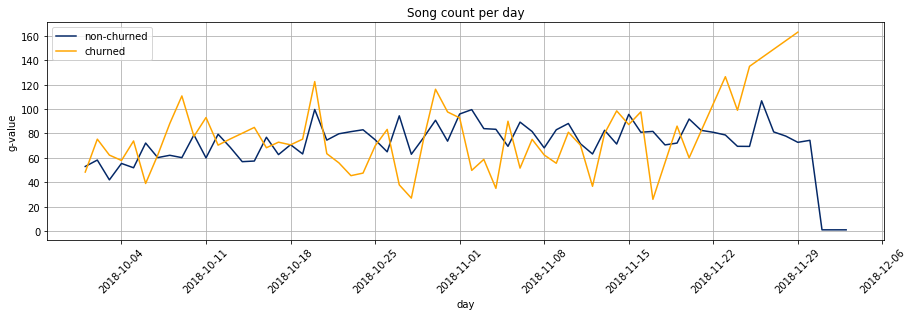

In [88]:
# Define f function
f_SongCountPerDay = user_log_valid \
    .where(user_log_valid.page == 'NextSong') \
    .groupby('userId', 'churn', col('date').alias('attribute')) \
    .agg(count('userId').alias('f-value'))

# Get g function
g_SongCountPerDay = get_g(f_SongCountPerDay)

# Plot it
plot_timeline(g_SongCountPerDay, 'Song count per day', 'day', 45)

If we calculate the delta over the whole observation period it is even more clear the difference between the two types of aggregations we have made.

In [89]:
g = g_SongCountPerDay \
    .groupby('churn') \
    .agg(Fsum('g-value').alias('g-value'))
deltaset = calc_delta(g)
deltaset.show()

+-----+-----------------+-------------------+--------------------+---------+
|churn|          g-value|              ratio|               delta|candidate|
+-----+-----------------+-------------------+--------------------+---------+
|    1|4045.339049138855|0.46979832347698064|-0.06040335304603872|    false|
|    0|4565.460195948425| 0.5302016765230193|-0.06040335304603861|    false|
+-----+-----------------+-------------------+--------------------+---------+



##### Song count per week of year

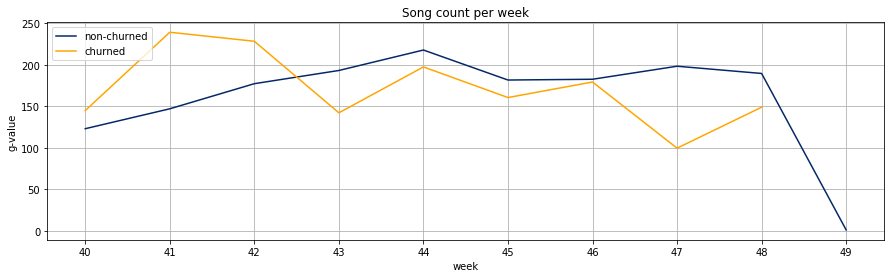

In [90]:
# Define f function
f_SongCountPerWeek = user_log_valid \
    .withColumn('weekOfYear', date_format(col('tsDate'), "w")) \
    .where(user_log_valid.page == 'NextSong') \
    .groupby('userId', 'churn', col('weekOfYear').alias('attribute')) \
    .agg(count('userId').alias('f-value'))

# Get g function
g_SongCountPerWeek = get_g(f_SongCountPerWeek)

# Plot it
plot_timeline(g_SongCountPerWeek, 'Song count per week', 'week')

In [91]:
# Delta over the whole observation period
g = g_SongCountPerWeek \
    .groupby('churn') \
    .agg(Fsum('g-value').alias('g-value'))
deltaset = calc_delta(g)
deltaset.show()

+-----+------------------+------------------+--------------------+---------+
|churn|           g-value|             ratio|               delta|candidate|
+-----+------------------+------------------+--------------------+---------+
|    1|1541.3752059356634| 0.488736624733305|-0.02252675053339004|    false|
|    0| 1612.419962938298|0.5112633752666951|-0.02252675053339015|    false|
+-----+------------------+------------------+--------------------+---------+



##### Song count per day of week

In [94]:
# Define f function
f_SongCountPerDayOfWeek = user_log_valid \
    .withColumn('dayOfWeek', date_format(col('date'), 'E')) \
    .withColumn('dayOfWeekNum', date_format(col('date'), "u")) \
    .where(user_log_valid.page == 'NextSong') \
    .groupby('userId', 'churn', 'dayOfWeekNum', 'dayOfWeek') \
    .agg(count('userId').alias('f-value'))

# Get g function
g_SongCountPerDayOfWeek = f_SongCountPerDayOfWeek \
    .groupby('churn', 'dayOfWeekNum', 'dayOfWeek') \
    .agg(avg('f-value').alias('g-value')) \
    .sort('dayOfWeekNum')

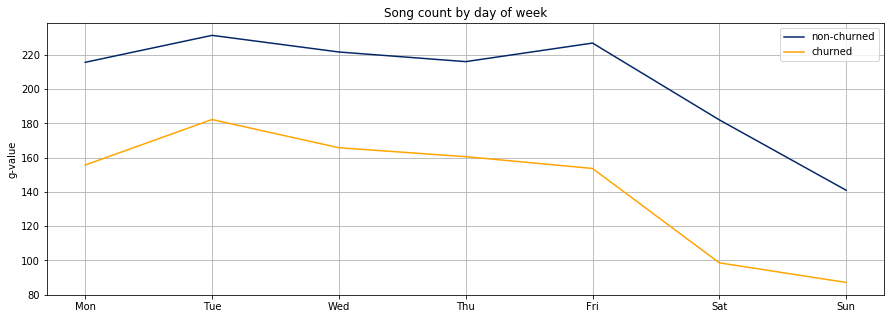

In [95]:
# Plot it
df = g_SongCountPerDayOfWeek.toPandas()
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)

# split by churn
df0 = df[df.churn == 0]
df1 = df[df.churn == 1]
ax.plot(df0['dayOfWeekNum'], df0['g-value'], color = '#042867')
ax.plot(df1['dayOfWeekNum'], df1['g-value'], color = 'orange')

labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax.set_xticklabels(labels)
ax.grid()
ax.set_ylabel('g-value')
ax.set_title('Song count by day of week')
plt.legend(['non-churned', 'churned'], loc=1)
plt.show()

In [96]:
# Delta over the whole observation period 
# We'll use a proper f function whose f-value represents an average of song count per day of week.
f = f_SongCountPerDayOfWeek \
    .groupby('userId', 'churn') \
    .agg(avg('f-value').alias('f-value'))

g = f.groupby('churn').agg(Fsum('f-value').alias('g-value'))

deltaset = calc_delta(g)
deltaset.show()

+-----+-----------------+-------------------+-------------------+---------+
|churn|          g-value|              ratio|              delta|candidate|
+-----+-----------------+-------------------+-------------------+---------+
|    1|6336.602380952381|0.17006487823022864|-0.6598702435395427|     true|
|    0|30923.30952380953| 0.8299351217697714|-0.6598702435395427|     true|
+-----+-----------------+-------------------+-------------------+---------+



##### Song count per hour of day

Counts song logs aggregated by hour of day.

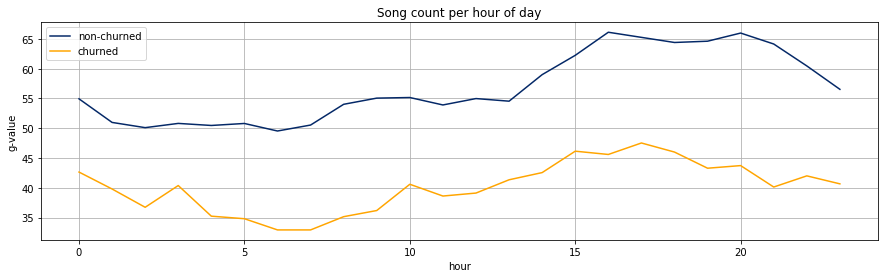

In [97]:
# Define f function
f_SongCountPerHourOfDay = user_log_valid \
    .withColumn('hour', hour(col('tsDate'))) \
    .where(user_log_valid.page == 'NextSong') \
    .groupby('userId', 'churn', col('hour').alias('attribute')) \
    .agg(count('userId').alias('f-value'))

# Get g function
g_SongCountPerHourOfDay = get_g(f_SongCountPerHourOfDay)

# Plot it
plot_timeline(g_SongCountPerHourOfDay, 'Song count per hour of day', 'hour')

In [98]:
# Delta over the whole observation period using a proper f function
f = f_SongCountPerHourOfDay \
    .groupby('userId', 'churn') \
    .agg(avg('f-value').alias('f-value'))

g = f.groupby('churn').agg(Fsum('f-value').alias('g-value'))

deltaset = calc_delta(g)
deltaset.show()

+-----+------------------+-------------------+-------------------+---------+
|churn|           g-value|              ratio|              delta|candidate|
+-----+------------------+-------------------+-------------------+---------+
|    1|1710.6372153209106|0.16862809237750515|-0.6627438152449897|     true|
|    0|  8433.80070841088| 0.8313719076224949|-0.6627438152449898|     true|
+-----+------------------+-------------------+-------------------+---------+



##### Total song length

Calculates the total length of all song events.

+-----+-------------+--------+---------+---------+
|churn|g-value      |ratio   |delta    |candidate|
+-----+-------------+--------+---------+---------+
|1    |174014.268551|0.386543|-0.226915|true     |
|0    |276166.937468|0.613457|-0.226915|true     |
+-----+-------------+--------+---------+---------+



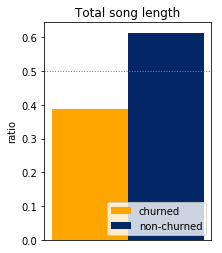

In [99]:
# Define f function
f_TotalSongLength = user_log_valid \
    .where(user_log_valid.page == 'NextSong') \
    .groupby('userId', 'churn') \
    .agg(Fsum('length').alias('f-value'))

# Get g function
g_TotalSongLength = get_g(f_TotalSongLength)

analyse(g_TotalSongLength, attr_dict=None, title='Total song length', loc=4, width=3, height=4);

##### Non-song count

Counts non-song page events.

+-----+----------+--------+---------+---------+
|churn|g-value   |ratio   |delta    |candidate|
+-----+----------+--------+---------+---------+
|1    |162.884615|0.402576|-0.194847|true     |
|0    |241.72093 |0.597424|-0.194847|true     |
+-----+----------+--------+---------+---------+



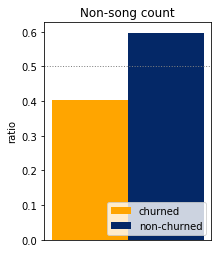

In [100]:
# Define f function
f_NonSongCount = user_log_valid \
    .where(user_log_valid.page != 'NextSong') \
    .groupby('userId', 'churn') \
    .agg(count('userId').alias('f-value'))

# Get g function
g_NonSongCount = get_g(f_NonSongCount)

analyse(g_NonSongCount, attr_dict=None, title='Non-song count', loc=4, width=3, height=4);

##### Unique song count

Counts unique songs.

+-----+----------+--------+---------+---------+
|churn|g-value   |ratio   |delta    |candidate|
+-----+----------+--------+---------+---------+
|1    |638.365385|0.395485|-0.209031|true     |
|0    |975.768786|0.604515|-0.209031|true     |
+-----+----------+--------+---------+---------+



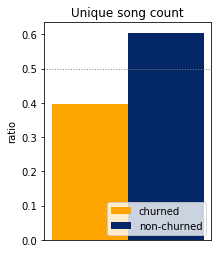

In [101]:
# Define f function
# Note: We use song column to identity the song.
f_UniqueSongCount = user_log_valid \
    .where(user_log_valid.page == 'NextSong') \
    .select('userId', 'churn', 'song') \
    .dropDuplicates() \
    .groupby('userId', 'churn') \
    .agg(count('userId').alias('f-value'))

# Get g function
g_UniqueSongCount = get_g(f_UniqueSongCount)

analyse(g_UniqueSongCount, attr_dict=None, title='Unique song count', loc=4, width=3, height=4);

#### 3.2.6.5. Session Level Analysis

##### Session count

+-----+---------+--------+---------+---------+
|churn|g-value  |ratio   |delta    |candidate|
+-----+---------+--------+---------+---------+
|1    |10.326923|0.403691|-0.192618|true     |
|0    |15.254335|0.596309|-0.192618|true     |
+-----+---------+--------+---------+---------+



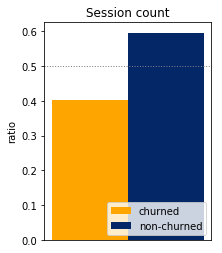

In [102]:
# Define f function
f_SessionCount = user_log_valid \
    .select( 'userId', 'churn', 'sessionId') \
    .dropDuplicates() \
    .groupby('userId', 'churn') \
    .agg(count('userId').alias('f-value'))

# Get g function
g_SessionCount = get_g(f_SessionCount)

analyse(g_SessionCount, attr_dict=None, title='Session count', loc=4, width=3, height=4);

##### Session count per day

+-----+--------+--------+--------+---------+
|churn|g-value |ratio   |delta   |candidate|
+-----+--------+--------+--------+---------+
|1    |1.201425|0.519021|0.038041|false    |
|0    |1.113367|0.480979|0.038041|false    |
+-----+--------+--------+--------+---------+



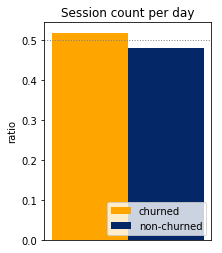

In [103]:
# Define f function
f_SessionCountPerDay = user_log_valid \
    .select( 'userId', 'churn', 'sessionId', 'date') \
    .dropDuplicates() \
    .groupby('userId', 'churn', 'date') \
    .count() \
    .groupby('userId', 'churn') \
    .agg(avg('count').alias('f-value'))

# Get g function
g_SessionCountPerDay = get_g(f_SessionCountPerDay)

analyse(g_SessionCountPerDay, attr_dict=None, title='Session count per day', loc=4, width=3, height=4);

##### Average session duration

+-----+------------+-------+--------+---------+
|churn|g-value     |ratio  |delta   |candidate|
+-----+------------+-------+--------+---------+
|1    |15574.471817|0.46658|-0.06684|false    |
|0    |17805.596824|0.53342|-0.06684|false    |
+-----+------------+-------+--------+---------+



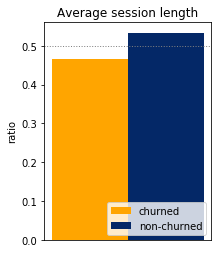

In [104]:
f_AvgSessionLength = user_log_valid \
    .groupby('userId', 'churn', 'sessionId') \
    .agg(((max('ts') - min('ts'))/1000).alias('sessionLength')) \
    .groupby('userId', 'churn') \
    .agg(avg('sessionLength').alias('f-value'))

# Get g function
g_AvgSessionLength = get_g(f_AvgSessionLength)

analyse(g_AvgSessionLength, attr_dict=None, title='Average session length', loc=4, width=3, height=4);

##### Average session gap

A *session gap* is a gap of no user activity between the sessions.

We are using the following formula to calculate the average session gap per user:

> average session gap = $\frac{observationTime - sessionTime}{sessionCount - 1}$

The dividend is a **total session gap time** per user and the divisor is the **number of gaps** between the sessions per user which equals the total number of sessions decreased by 1 given that *n* sessions have *n $-$ 1* gaps.

+-----+--------------+--------+---------+---------+
|churn|g-value       |ratio   |delta    |candidate|
+-----+--------------+--------+---------+---------+
|1    |2276674.784306|0.348204|-0.303592|true     |
|0    |4261658.171781|0.651796|-0.303592|true     |
+-----+--------------+--------+---------+---------+



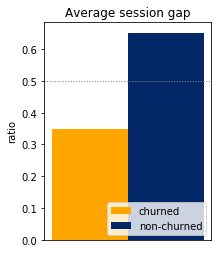

In [105]:
# Define f function
f_AvgSessionGap = user_log_valid \
    .groupby('userId', 'churn', 'sessionId') \
    .agg(min('ts').alias('startTime'), max('ts').alias('endTime')) \
    .groupby('userId', 'churn') \
    .agg(count('userId').alias('sessionCount'), \
        ((max('endTime') - min('startTime'))/1000).alias('observationPeriodTime'), \
        (Fsum(col('endTime') - col('startTime'))/1000).alias('totalSessionTime')) \
    .where(col('sessionCount') > 1) \
    .select('userId', 'churn', \
            (col('observationPeriodTime') - col('totalSessionTime')/(col('sessionCount') - 1)).alias('f-value'))

# Get g function
g_AvgSessionGap = get_g(f_AvgSessionGap)

analyse(g_AvgSessionGap, attr_dict=None, title='Average session gap', loc=4, width=3, height=4);

#### 3.2.6.6. Page Level Analysis

In [106]:
def filter_page(data, event):
    """
    Description: 
        Page logs filtered by event.
    
    Args:
        data (DataFrame): a data set.
        event (str): an event's name (or page attribute).
    """
    return data.where(data.page == event)

*Remark on excluded events:*

I'll check the delta values for each page event except for the *Cancel*, *Cancellation Confirmation*, and *Submit Downgrade* events. The reason why we exclude the *Cancel* and *Cancellation Confirmation* event is that I use the latter to **define** our label - *it is a part of the label definition of cancelled users*, and since the *Cancel* event is its predecessor event I have to exclude it too. The *Submit Downgrade* event is used *to define the label of the downgraded users*. The same is true for *Downgrade* event. I prefer not to use any feature that is part of the label definition of the other churn type. 

In [107]:
# Let's check if the predecessor of every Cancellation Confirmation event is the Cancel event 
# and if the predecessor of every Cancellation Confirmation event is the Cancel event.
print(f"Total of Cancel events: {filter_page(user_log_valid, 'Cancel').count()}")
print(f"Total of Cancellation Confirmation events: {filter_page(user_log_valid, 'Cancellation Confirmation').count()}")
cancelConfirmationLogs = user_log_valid.where(user_log_valid.page == 'Cancellation Confirmation').select(col('userRowId').alias('rowId'))
cancelWithConfirmationLogs = user_log_valid.where(user_log_valid.page == 'Cancel') \
    .join(cancelConfirmationLogs, cancelConfirmationLogs.rowId == user_log_valid.userRowId + 1);
print(f'Total of Cancel -> Cancellation Confirmation events: {cancelWithConfirmationLogs.count()}')

Total of Cancel events: 52
Total of Cancellation Confirmation events: 52
Total of Cancel -> Cancellation Confirmation events: 52


In [108]:
# Exclude events that form part of the label definition (of both churn types)
page_user_log_valid = user_log_valid.where(~user_log_valid.page.isin(['Cancel', 'Cancellation Confirmation', 'Submit Downgrade', 'Downgrade']))

##### Page count

+-----+---------------+----------+--------+---------+---------+
|churn|attribute      |g-value   |ratio   |delta    |candidate|
+-----+---------------+----------+--------+---------+---------+
|1    |About          |1.806452  |0.337858|-0.324284|true     |
|0    |About          |3.540323  |0.662142|-0.324284|true     |
|1    |Add Friend     |14.454545 |0.391405|-0.217189|true     |
|0    |Add Friend     |22.475309 |0.608595|-0.217189|true     |
|1    |Add to Playlist|20.76     |0.384298|-0.231404|true     |
|0    |Add to Playlist|33.260606 |0.615702|-0.231404|true     |
|1    |Error          |1.454545  |0.385787|-0.228426|true     |
|0    |Error          |2.315789  |0.614213|-0.228426|true     |
|1    |Help           |5.55814   |0.405334|-0.189333|true     |
|0    |Help           |8.154362  |0.594666|-0.189333|true     |
|1    |Home           |32.784314 |0.401377|-0.197247|true     |
|0    |Home           |48.895349 |0.598623|-0.197247|true     |
|1    |Logout         |12.021739 |0.4289

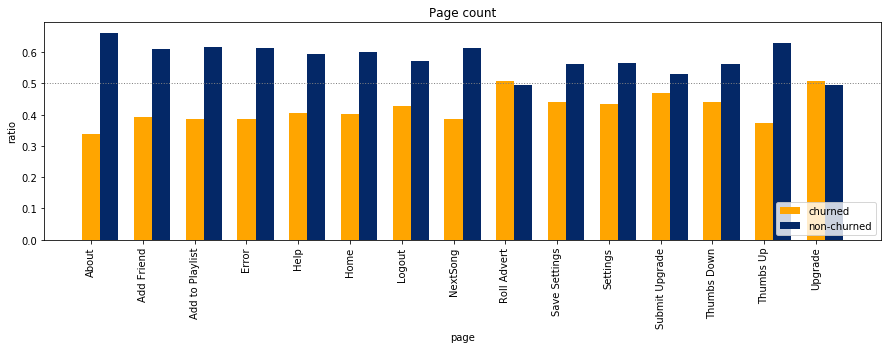

In [109]:
# Get f function by attribute and analyse it
f_PageCount = get_f_LogAttributeCount(page_user_log_valid, 'page')

# Get g function
g = get_g(f_PageCount)

# Define attribute
attr_dict = get_attribute(page_user_log_valid, 'page')

analyse(g, attr_dict=attr_dict, title='Page count', loc=4, width=15, height=4, rotation=90);

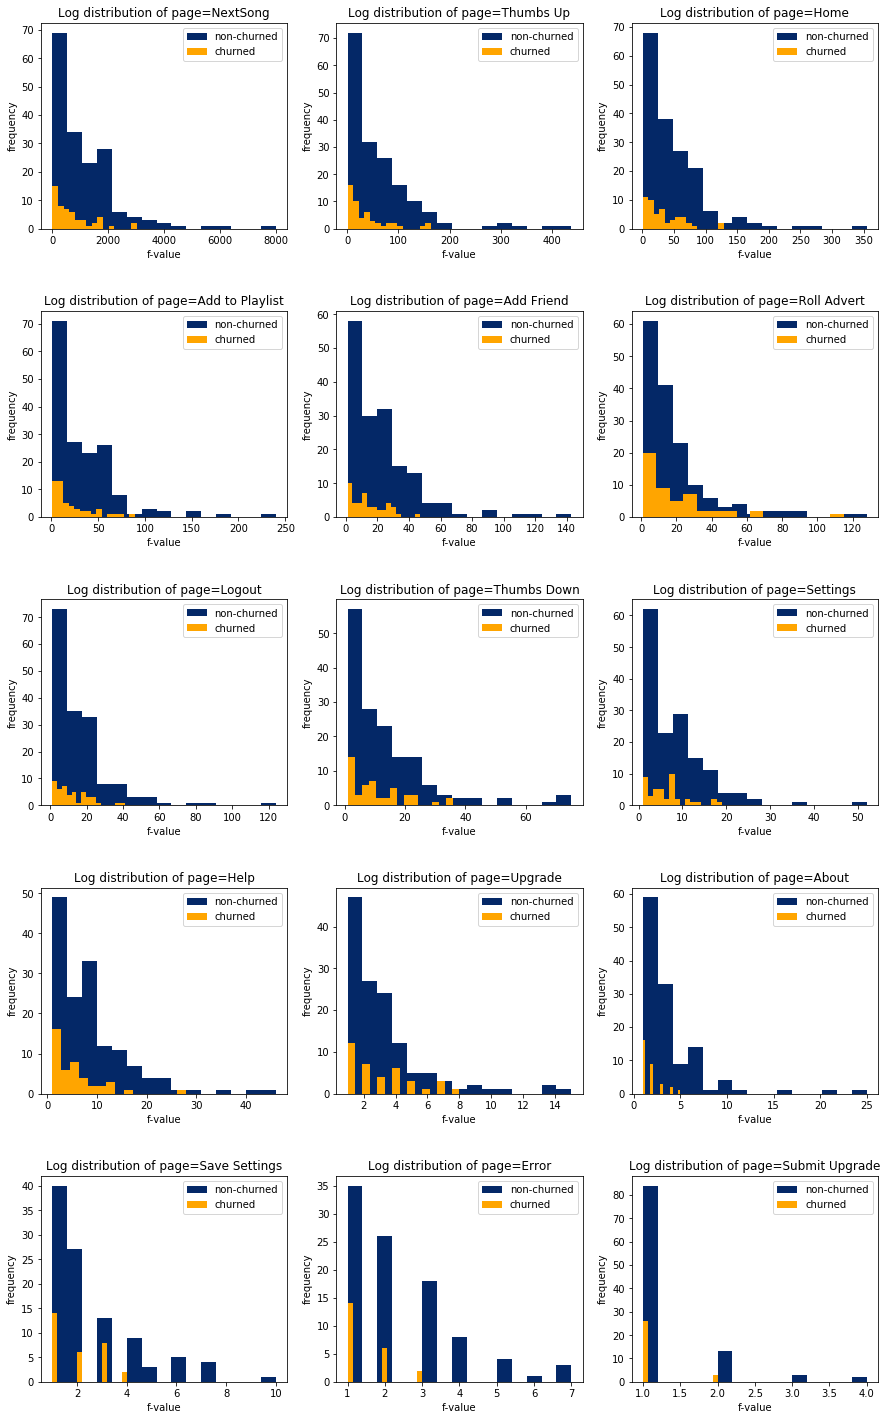

In [110]:
# Show distribution of f-values
plot_hist(f_PageCount, attr_dict, 'Distribution of page logs', bins=15, width=15, height=25)

##### Page count per session hour

Counts page events per session hour.

+-----+---------------+---------+--------+---------+---------+
|churn|attribute      |g-value  |ratio   |delta    |candidate|
+-----+---------------+---------+--------+---------+---------+
|1    |About          |1.857849 |0.832283|0.664566 |true     |
|0    |About          |0.374383 |0.167717|0.664566 |true     |
|1    |Add Friend     |1.117357 |0.064878|-0.870245|true     |
|0    |Add Friend     |16.105203|0.935122|-0.870245|true     |
|1    |Add to Playlist|0.701903 |0.37598 |-0.24804 |true     |
|0    |Add to Playlist|1.16496  |0.62402 |-0.24804 |true     |
|1    |Error          |0.233763 |0.537165|0.07433  |false    |
|0    |Error          |0.201416 |0.462835|0.07433  |false    |
|1    |Help           |0.375415 |0.496872|-0.006256|false    |
|0    |Help           |0.380142 |0.503128|-0.006256|false    |
|1    |Home           |21.073688|0.549619|0.099238 |false    |
|0    |Home           |17.268663|0.450381|0.099238 |false    |
|1    |Logout         |92.287866|0.782793|0.565586 |tru

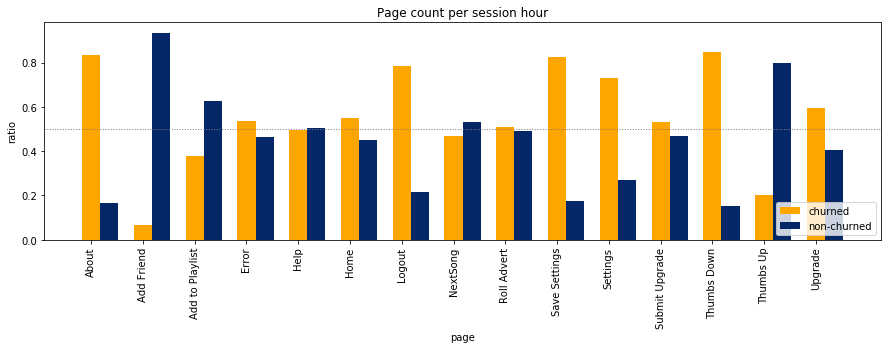

In [111]:
# Define session length (in hours)
sessionLength = user_log_valid \
    .groupby('userId', 'sessionId') \
    .agg(((max('ts') - min('ts'))/1000/3600).alias('sessionLength'))

# Define f function
f_PageCountPerSessionHour = page_user_log_valid \
    .join(sessionLength, on=['userId', 'sessionId'], how='inner') \
    .groupby('userId', 'churn', 'page', 'sessionId', 'sessionLength') \
    .agg((count('userId')/col('sessionLength')).alias('pageCountPerHour')) \
    .groupby('userId', 'churn', 'page') \
    .agg(avg('pageCountPerHour').alias('f-value')) \
    .select('userId', 'churn', col('page').alias('attribute'), 'f-value')

# Get g function
g = get_g(f_PageCountPerSessionHour)

# Define attribute
attr_dict = get_attribute(page_user_log_valid, 'page')

analyse(g, attr_dict=attr_dict, \
        title='Page count per session hour', loc=4, width=15, height=4, rotation=90);

##### Page count per hour

+-----+---------------+---------+--------+---------+---------+
|churn|attribute      |g-value  |ratio   |delta    |candidate|
+-----+---------------+---------+--------+---------+---------+
|1    |About          |0.038636 |0.468509|-0.062982|false    |
|0    |About          |0.04383  |0.531491|-0.062982|false    |
|1    |Add Friend     |0.358796 |0.516598|0.033196 |false    |
|0    |Add Friend     |0.33574  |0.483402|0.033196 |false    |
|1    |Add to Playlist|0.468369 |0.530474|0.060948 |false    |
|0    |Add to Playlist|0.414556 |0.469526|0.060948 |false    |
|1    |Error          |0.032598 |0.493312|-0.013375|false    |
|0    |Error          |0.033482 |0.506688|-0.013375|false    |
|1    |Help           |0.107449 |0.488919|-0.022161|false    |
|0    |Help           |0.112319 |0.511081|-0.022161|false    |
|1    |Home           |0.903384 |0.542083|0.084166 |false    |
|0    |Home           |0.763121 |0.457917|0.084166 |false    |
|1    |Logout         |0.282592 |0.531547|0.063095 |fal

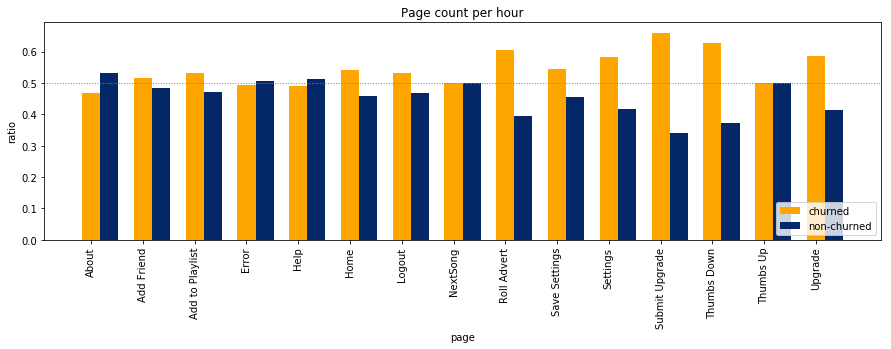

In [112]:
# Define total session length (in hours)
totalSessionLength = sessionLength \
    .groupby('userId') \
    .agg(Fsum('sessionLength').alias('totalSessionLength'))

# Define f function
f_PageCountPerHour = page_user_log_valid \
    .join(totalSessionLength, 'userId', 'inner') \
    .groupby('userId', 'churn', 'page', 'totalSessionLength') \
    .agg((count('userId')/col('totalSessionLength')).alias('f-value')) \
    .select('userId', 'churn', col('page').alias('attribute'), 'f-value')

# Get g function
g = get_g(f_PageCountPerHour)

# Define attribute
attr_dict = get_attribute(page_user_log_valid, 'page')

analyse(g, attr_dict=attr_dict, \
        title='Page count per hour', loc=4, width=15, height=4, rotation=90);

##### Page count per day

+-----+---------------+---------+--------+---------+---------+
|churn|attribute      |g-value  |ratio   |delta    |candidate|
+-----+---------------+---------+--------+---------+---------+
|1    |About          |1.099462 |0.487173|-0.025653|false    |
|0    |About          |1.157357 |0.512827|-0.025653|false    |
|1    |Add Friend     |2.540047 |0.480898|-0.038204|false    |
|0    |Add Friend     |2.741836 |0.519102|-0.038204|false    |
|1    |Add to Playlist|2.669646 |0.485357|-0.029286|false    |
|0    |Add to Playlist|2.830732 |0.514643|-0.029286|false    |
|1    |Error          |1.068182 |0.492583|-0.014834|false    |
|0    |Error          |1.100351 |0.507417|-0.014834|false    |
|1    |Help           |1.336148 |0.479431|-0.041137|false    |
|0    |Help           |1.450795 |0.520569|-0.041137|false    |
|1    |Home           |3.492681 |0.510368|0.020736 |false    |
|0    |Home           |3.350775 |0.489632|0.020736 |false    |
|1    |Logout         |1.819513 |0.51696 |0.033919 |fal

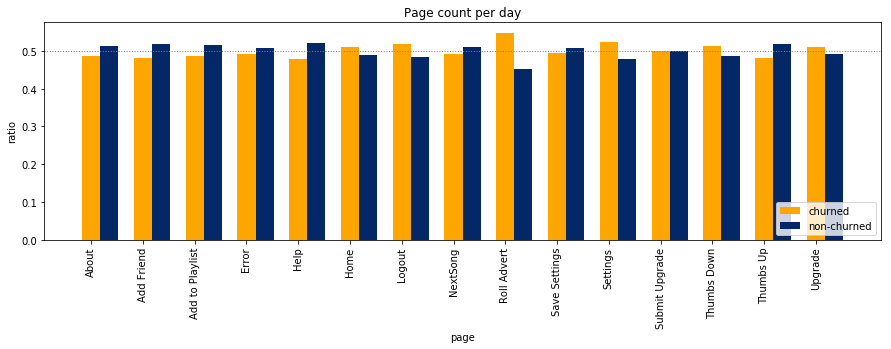

In [113]:
# Define f function
f_PageCountPerDay = page_user_log_valid \
    .groupby('userId', 'churn', 'page', 'date') \
    .count() \
    .groupby('userId', 'churn', 'page') \
    .agg(avg('count').alias('f-value')) \
    .select('userId', 'churn', col('page').alias('attribute'), 'f-value')

# Get g function
g = get_g(f_PageCountPerDay)

# Define attribute
attr_dict = get_attribute(page_user_log_valid, 'page')

analyse(g, attr_dict=attr_dict, \
        title='Page count per day', loc=4, width=15, height=4, rotation=90);

# 4. Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

All the features that were marked as **candidate features** (that did fulfill the delta threshold condition) are listed here.

### 4.1. Log attribute features

> - *Log Count*
> - *Gender Count*
> - *Method Count*
> - *Status Count*

In [114]:
def statusCount(status):
    """
    Description:
        Returns log count query filtered by a specified status.
        
    Args:
        status (DataFrame): an attribute value.
        
    Returns:
        DataFrame: a dataframe query.
    """
    
    return user_log_valid \
        .where(user_log_valid.status == status) \
        .groupby('userId') \
        .agg(count('userId').alias('Status' + str(status) + 'Count'))

In [115]:
# Log count
f_LogCount = user_log_valid \
    .groupby('userId') \
    .agg(count('userId').alias('LogCount'))

# Gender count
f_GenderCount = user_log_valid \
    .select('userId', 'gender') \
    .dropDuplicates() \
    .replace(['M', 'F'], ['0', '1'], 'gender') \
    .select('userId', col('gender').cast('int').alias('Gender'))

# Method PUT count
f_MethodPutCount = user_log_valid \
    .where(user_log_valid.method == 'PUT') \
    .groupby('userId') \
    .agg(count('userId').alias('MethodPutCount'))

# Status count
f_Status200Count = statusCount(200)
f_Status307Count = statusCount(307)
f_Status404Count = statusCount(404)

### 4.2. Session features

> - *Session count*
> - *Average session gap*

In [116]:
# Total session count
f_SessionCount = user_log_valid \
    .select('userId', 'sessionId') \
    .dropDuplicates() \
    .groupby('userId') \
    .agg(count('userId').alias('SessionCount'))

# Average session gap
f_AvgSessionGap = user_log_valid \
    .groupby('userId', 'sessionId') \
    .agg(min('ts').alias('startTime'), max('ts').alias('endTime')) \
    .groupby('userId') \
    .agg(count('userId').alias('sessionCount'), \
        ((max('endTime') - min('startTime'))/1000).alias('observationPeriodTime'), \
        (Fsum(col('endTime') - col('startTime'))/1000).alias('totalSessionTime')) \
    .where(col('sessionCount') > 1) \
    .join(user_log_valid.select('userId').dropDuplicates(), 'userId', 'outer') \
    .fillna(0) \
    .select('userId', \
            (col('observationPeriodTime') - col('totalSessionTime')/(col('sessionCount') - 1)).alias('AvgSessionGap'))

# Average session count per day (Not used)
f_SessionsPerDay = user_log_valid \
    .select('userId', 'date', 'sessionId') \
    .dropDuplicates() \
    .groupby('userId', 'date') \
    .count() \
    .groupby('userId') \
    .agg(avg('count').alias('SessionsPerDay'))

# Average session length (Not used)
f_AvgSessionLength = user_log_valid \
    .groupby('userId', 'sessionId') \
    .agg(((max('ts') - min('ts'))/1000).alias('sessionLength')) \
    .groupby('userId') \
    .agg(avg('sessionLength').alias('AvgSessionLength'))

### 4.3. Song features

> - *Song count*
> - *Song count per day of the week*
> - *Song count per hour of the day*
> - *Non-song count*
> - *Total song length*
> - *Unique song count*
> - *Unique song share*

In [117]:
# Song event count
f_SongCount = user_log_valid \
    .where(user_log_valid.page == 'NextSong') \
    .groupby('userId') \
    .agg(count('userId').alias('SongCount'))

# Song count per day of the week
f_SongCountPerDayOfWeek = user_log_valid \
    .withColumn('dayOfWeek', date_format(col('date'), 'E')) \
    .withColumn('dayOfWeekNum', date_format(col('date'), "u")) \
    .where(user_log_valid.page == 'NextSong') \
    .groupby('userId', 'churn', 'dayOfWeekNum', 'dayOfWeek') \
    .agg(count('userId').alias('SongsPerDayOfWeek')) \
    .select('userId', col('SongsPerDayOfWeek').cast('int'))

# Song count per hour of the day
f_SongCountPerHourOfDay = user_log_valid \
    .withColumn('hour', hour(col('tsDate'))) \
    .where(user_log_valid.page == 'NextSong') \
    .groupby('userId', 'churn', col('hour').alias('attribute')) \
    .agg(count('userId').alias('SongsPerHour')) \
    .select('userId', col('SongsPerHour').cast('int'))

# Non-song event count
f_NonSongCount = user_log_valid \
    .where(user_log_valid.page != 'NextSong') \
    .groupby('userId') \
    .agg(count('userId').alias('NonSongCount'))

# All song total length  
f_TotalSongLength = user_log_valid \
    .where(user_log_valid.page == 'NextSong') \
    .select('userId', 'length') \
    .groupby('userId') \
    .agg(Fsum('length').alias('TotalSongLength'))

# Unique song event count
f_UniqueSongCount = user_log_valid \
    .where(user_log_valid.page == 'NextSong') \
    .select('userId', 'song') \
    .dropDuplicates() \
    .groupby('userId') \
    .agg(count('userId').alias('UniqueSongCount'))

# Share of unique song events among all song events
totals = user_log_valid \
    .where(user_log_valid.page == 'NextSong') \
    .select('userId') \
    .groupby('userId') \
    .agg(count('userId').alias('total'))

f_UniqueSongShare = user_log_valid \
    .where(user_log_valid.page == 'NextSong') \
    .select('userId', 'song') \
    .dropDuplicates() \
    .groupby('userId') \
    .count() \
    .join(totals, on = ['userId'], how = 'inner') \
    .select('userId', (col('count')/col('total')).alias('UniqueSongShare'))


# Song count per day (Not used)
f_SongCountPerDay = user_log_valid \
    .where(user_log_valid.page == 'NextSong') \
    .groupby('userId') \
    .agg(count('userId').alias('SongCount'))

### 4.4. Page features

> - *About page count*
> - *Add Friend page count*
> - *Add to Playlist page count*
> - *Error page count*
> - *Help page count*
> - *Home page count*
> - *Logout page count*
> - *NextSong page count*
> - *Thumbs Up page count*

-----------------------------------------------------

> - *About page count per session hour*
> - *Add Friend page count per session hour*
> - *Add to Playlist page count per session hour*
> - *Logout page count per session hour*
> - *Save Settings page count per session hour*
> - *Settings page count per session hour*
> - *Thumbs Down page count per session hour*
> - *Thumbs Up page count per session hour*
> - *Upgrade page count per session hour*

-----------------------------------------------------

> - *Roll Advert page count per hour*
> - *Settings page count per hour*
> - *Submit Upgrade page count per hour*
> - *Thumbs Down page count per hour*
> - *Upgrade page count per hour*

-----------------------------------------------------


In [118]:
def page_count(page):
    """
    Description:
        Returns the count of each user's visits to a specific page.
        
    Args:
        page (str): an page value.
        
    Returns:
        DataFrame: a dataframe query.
    """
    return user_log_valid \
        .where(user_log_valid.page == page) \
        .groupby('userId') \
        .agg(count('userId').alias('count')) \
        .select('userId', col('count').alias(page.replace(' ', '') + 'Count'))

In [119]:
f_AboutCount = page_count('About')
f_AddFriendCount = page_count('Add Friend')
f_AddToPlaylistCount = page_count('Add to Playlist')
f_ErrorCount = page_count('Error')
f_HelpCount = page_count('Help')
f_HomeCount = page_count('Home')
f_LogoutCount = page_count('Logout')
f_NextSongCount = page_count('NextSong')
f_ThumbsUpCount = page_count('Thumbs Up')

In [120]:
page_data = user_log_valid \
    .where(~user_log_valid.page.isin(['Cancel', 'Cancellation Confirmation', 'Submit Downgrade'])) \
    .select('page', 'userId', 'sessionId', 'ts', 'date')

In [121]:
# Average page count per session hour
session_hours = page_data \
    .groupby('userId', 'sessionId') \
    .agg(((max('ts') - min('ts'))/1000/3600).alias('sessionHours'))

def page_session_hour(page):
    """
    Description:
       Returns the number of times a user visited a specific page during a session hour.
        
    Args:
        page (str): an page value.
        
    Returns:
        DataFrame: a dataframe query.
    """
    
    return page_data \
        .where(user_log_valid.page == page) \
        .join(session_hours, ['userId', 'sessionId'], 'inner') \
        .groupby( 'userId', 'sessionId', 'sessionHours') \
        .agg((count('userId')/col('sessionHours')).alias('avgPerSession')) \
        .groupby('userId') \
        .agg(avg('avgPerSession').alias('avg')) \
        .select('userId', col('avg').alias(page.replace(' ', '') + 'PerSessionHour'))

In [122]:
f_AboutPerSessionHour = page_session_hour('About')
f_AddFriendPerSessionHour = page_session_hour('Add Friend')
f_AddToPlaylistPerSessionHour = page_session_hour('Add to Playlist')
f_LogoutPerSessionHour = page_session_hour('Logout')
f_SaveSettingsPerSessionHour = page_session_hour('Save Settings')
f_SettingsPerSessionHour = page_session_hour('Settings')
f_ThumbsDownPerSessionHour = page_session_hour('Thumbs Down')
f_ThumbsUpPerSessionHour = page_session_hour('Thumbs Up')
f_UpgradePerSessionHour = page_session_hour('Upgrade')

In [123]:
# Average page count per hour
user_hours = page_data \
    .groupby('userId', 'sessionId') \
    .agg(((max('ts') - min('ts'))/1000/3600).alias('sessionHours')) \
    .groupby('userId') \
    .agg(Fsum('sessionHours').alias('hours'))

def page_hour(page):
    """
    Description:
        This function returns the number of times a user visited a specific page in an hour.
        
    Args:
        page (str): an page value.
        
    Returns:
        DataFrame: a dataframe query.
    """
    
    return page_data \
        .where(user_log_valid.page == page) \
        .join(user_hours, 'userId', 'inner') \
        .groupby('userId', 'hours') \
        .agg((count('userId')/col('hours')).alias('avg')) \
        .select('userId', col('avg').alias(page.replace(' ', '') + 'PerHour'))

In [124]:
f_RollAdvertPerHour = page_hour('Roll Advert')
f_SettingsPerHour = page_hour('Settings')
f_SubmitUpgradePerHour = page_hour('Submit Upgrade')
f_ThumbsDownPerHour = page_hour('ThumbsDown')
f_UpgradePerHour = page_hour('Upgrade')

## 5. Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set.

### Sample (mini) dataset
> - size: **125MB**
> - row count: **286,500**
> - user count: **225**
> - data source: **mini_sparkify_event_data.json**
> - executed on: **local machine**

In [126]:
# Query for labels
data_labels = user_log_valid.select(col('churn').alias('label'), 'userId').dropDuplicates()

In [127]:
# Model's data (36 features)
data_features = data_labels.join(f_LogCount, 'userId', 'outer') \
    .join(f_GenderCount, 'userId', 'outer') \
    .join(f_MethodPutCount, 'userId', 'outer') \
    .join(f_Status200Count, 'userId', 'outer') \
    .join(f_Status307Count, 'userId', 'outer') \
    .join(f_Status404Count, 'userId', 'outer') \
    .join(f_SessionCount, 'userId', 'outer') \
    .join(f_AvgSessionGap, 'userId', 'outer') \
    .join(f_SongCount, 'userId', 'outer') \
    .join(f_SongCountPerDayOfWeek, 'userId', 'outer') \
    .join(f_SongCountPerHourOfDay, 'userId', 'outer') \
    .join(f_NonSongCount, 'userId', 'outer') \
    .join(f_TotalSongLength, 'userId', 'outer') \
    .join(f_UniqueSongCount, 'userId', 'outer') \
    .join(f_UniqueSongShare, 'userId', 'outer') \
    .join(f_AboutCount, 'userId', 'outer') \
    .join(f_AddFriendCount, 'userId', 'outer') \
    .join(f_AddToPlaylistCount, 'userId', 'outer') \
    .join(f_ErrorCount, 'userId', 'outer') \
    .join(f_HelpCount, 'userId', 'outer') \
    .join(f_HomeCount, 'userId', 'outer') \
    .join(f_LogoutCount, 'userId', 'outer') \
    .join(f_NextSongCount, 'userId', 'outer') \
    .join(f_ThumbsUpCount, 'userId', 'outer') \
    .join(f_AboutPerSessionHour, 'userId', 'outer') \
    .join(f_AddFriendPerSessionHour, 'userId', 'outer') \
    .join(f_AddToPlaylistPerSessionHour, 'userId', 'outer') \
    .join(f_LogoutPerSessionHour, 'userId', 'outer') \
    .join(f_SaveSettingsPerSessionHour, 'userId', 'outer') \
    .join(f_SettingsPerSessionHour, 'userId', 'outer') \
    .join(f_ThumbsDownPerSessionHour, 'userId', 'outer') \
    .join(f_ThumbsUpPerSessionHour, 'userId', 'outer') \
    .join(f_UpgradePerSessionHour, 'userId', 'outer') \
    .drop('userId') \
    .fillna(0)

## 5.1. Metrics

For the machine learning model evaluation, selecting the appropriate metrics is critical. The issue is that the class of churned users is unbalanced due to the dataset's unequal distribution. In the situation of unequal classes, accuracy is misleading and should not be used. Instead, we'll employ precision-recall metrics. The precision indicates the percentage of churned users we successfully identified among all churned users, whereas the recall indicates the percentage of churned users we successfully identified among all churned users:

> precision = $\frac{TP}{TP+FP}$

> recall = $\frac{TP}{TP+FN}$

True positives are correctly identified churned users, false positives are non-churned users incorrectly identified as churned users, and false negatives are churned users incorrectly identified as non-churned users, and FN are false negatives are churned users incorrectly identified as non-churned users.

In most cases, the classes aren't distributed uniformly. There will always be a grey zone where classes are jumbled together since we cannot always clearly differentiate all points of a positive class from all points of a negative class. As a result, there is an inverse relationship between precision and recall: raising one parameter (precision or recall) decreases the other (recall or precision). The precision-recall tradeoff is what it's called.

We want to establish a compromise between the precision and recall metrics in this case. Neither too many false positives nor too many false negatives are desirable. As a result, we'll utilize F1-score as our primary statistic, which is defined as:

> F1 = $2 * \frac{precision*recall}{precision+recall}$

F1 is the harmonic mean of precision and recall; it combines the two metrics into a single metric that gives them equal weight - just what we need.

## 5.2 Analysis of Features Correlation

### 5.2.1. First Correlation Analysis

In most cases, correlation analysis comes before feature engineering. Our path was different.  To initiate the correlation analysis, we now use only our 36 selected features. 

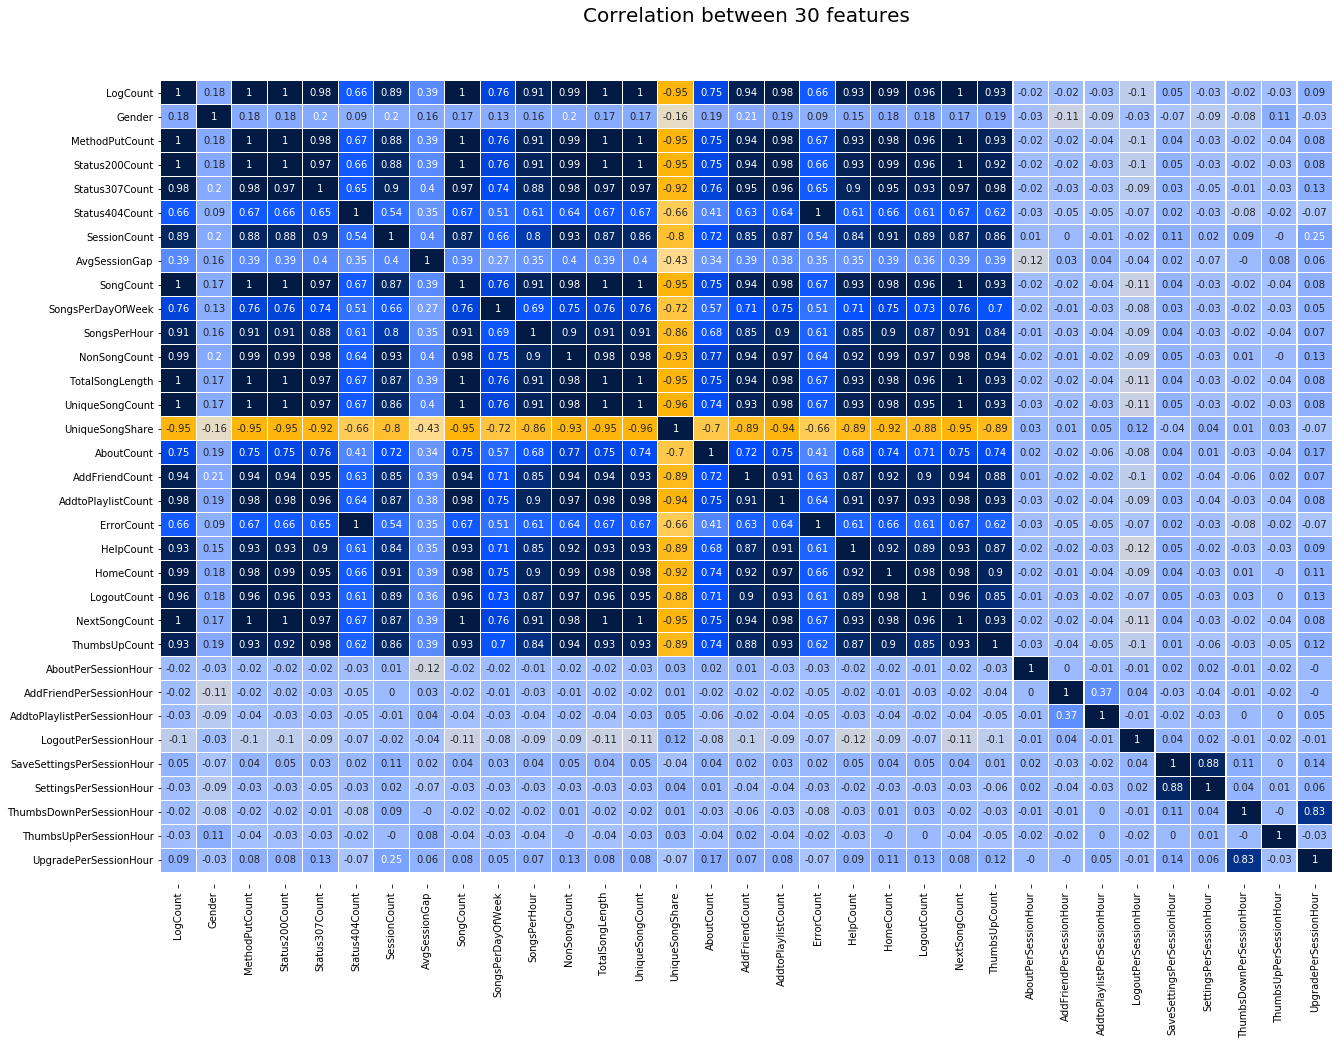

In [134]:
corr_df = data_features.toPandas()

# Plot correlation heatmap
plt.figure(figsize = [21, 15])
plt.title('Correlation between 36 features', y=1.05, size=20)
ax = sb.heatmap(corr_df.iloc[:, 1:].corr().round(2), annot=True, 
                square=False,
                cbar=False, linewidth=0.2,
                cmap = sparkify_cmap,
                vmin = -1, vmax = 1)
plt.yticks(rotation = 0)

# Correct plot cut off (Note: we must fix it due to the bug in the matplotlib 3.1.1)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [135]:
# Make a list of correlation coefficient means (absolute values) in the order of weaker to stronger correlation
corr = corr_df.iloc[:, 1:].corr()
corr.apply(lambda x : np.mean(abs(x))).sort_values()

AboutPerSessionHour            0.052222
ThumbsUpPerSessionHour         0.057461
AddFriendPerSessionHour        0.065549
AddtoPlaylistPerSessionHour    0.073059
ThumbsDownPerSessionHour       0.083690
SettingsPerSessionHour         0.089510
SaveSettingsPerSessionHour     0.097232
LogoutPerSessionHour           0.098211
UpgradePerSessionHour          0.132979
Gender                         0.169106
AvgSessionGap                  0.301092
Status404Count                 0.464521
ErrorCount                     0.464521
SongsPerDayOfWeek              0.499891
AboutCount                     0.503081
SessionCount                   0.587273
SongsPerHour                   0.590038
HelpCount                      0.602771
AddFriendCount                 0.610778
ThumbsUpCount                  0.611034
UniqueSongShare                0.615152
LogoutCount                    0.617125
AddtoPlaylistCount             0.633202
HomeCount                      0.634867
Status307Count                 0.635579


We can detect variables that are strongly correlated by observing these zones of positive and negative correlation, and these variables will be deselected from our list of selected features.

* MethodPutCount
* LogCount
* Status200Count
* Status307Count 

The coefficient mean - 0.643714, 0.643606, 0.642691, 0.635579 - confirms the strong similarity. Because there are so many features, I prefer to remove them and then plot the correlation heatmap again before continuing.

So, we'll start removing four features from the initial 36 features of the best model in the sample dataset.

### 5.2.2. Second Correlation Analysis

In [136]:
# Model's data (32 features)
data_features = data_labels.join(f_GenderCount, 'userId', 'outer') \
    .join(f_Status404Count, 'userId', 'outer') \
    .join(f_SessionCount, 'userId', 'outer') \
    .join(f_AvgSessionGap, 'userId', 'outer') \
    .join(f_SongCount, 'userId', 'outer') \
    .join(f_SongCountPerDayOfWeek, 'userId', 'outer') \
    .join(f_SongCountPerHourOfDay, 'userId', 'outer') \
    .join(f_NonSongCount, 'userId', 'outer') \
    .join(f_TotalSongLength, 'userId', 'outer') \
    .join(f_UniqueSongCount, 'userId', 'outer') \
    .join(f_UniqueSongShare, 'userId', 'outer') \
    .join(f_AboutCount, 'userId', 'outer') \
    .join(f_AddFriendCount, 'userId', 'outer') \
    .join(f_AddToPlaylistCount, 'userId', 'outer') \
    .join(f_ErrorCount, 'userId', 'outer') \
    .join(f_HelpCount, 'userId', 'outer') \
    .join(f_HomeCount, 'userId', 'outer') \
    .join(f_LogoutCount, 'userId', 'outer') \
    .join(f_NextSongCount, 'userId', 'outer') \
    .join(f_ThumbsUpCount, 'userId', 'outer') \
    .join(f_AboutPerSessionHour, 'userId', 'outer') \
    .join(f_AddFriendPerSessionHour, 'userId', 'outer') \
    .join(f_AddToPlaylistPerSessionHour, 'userId', 'outer') \
    .join(f_LogoutPerSessionHour, 'userId', 'outer') \
    .join(f_SaveSettingsPerSessionHour, 'userId', 'outer') \
    .join(f_SettingsPerSessionHour, 'userId', 'outer') \
    .join(f_ThumbsDownPerSessionHour, 'userId', 'outer') \
    .join(f_ThumbsUpPerSessionHour, 'userId', 'outer') \
    .join(f_UpgradePerSessionHour, 'userId', 'outer') \
    .drop('userId') \
    .fillna(0)

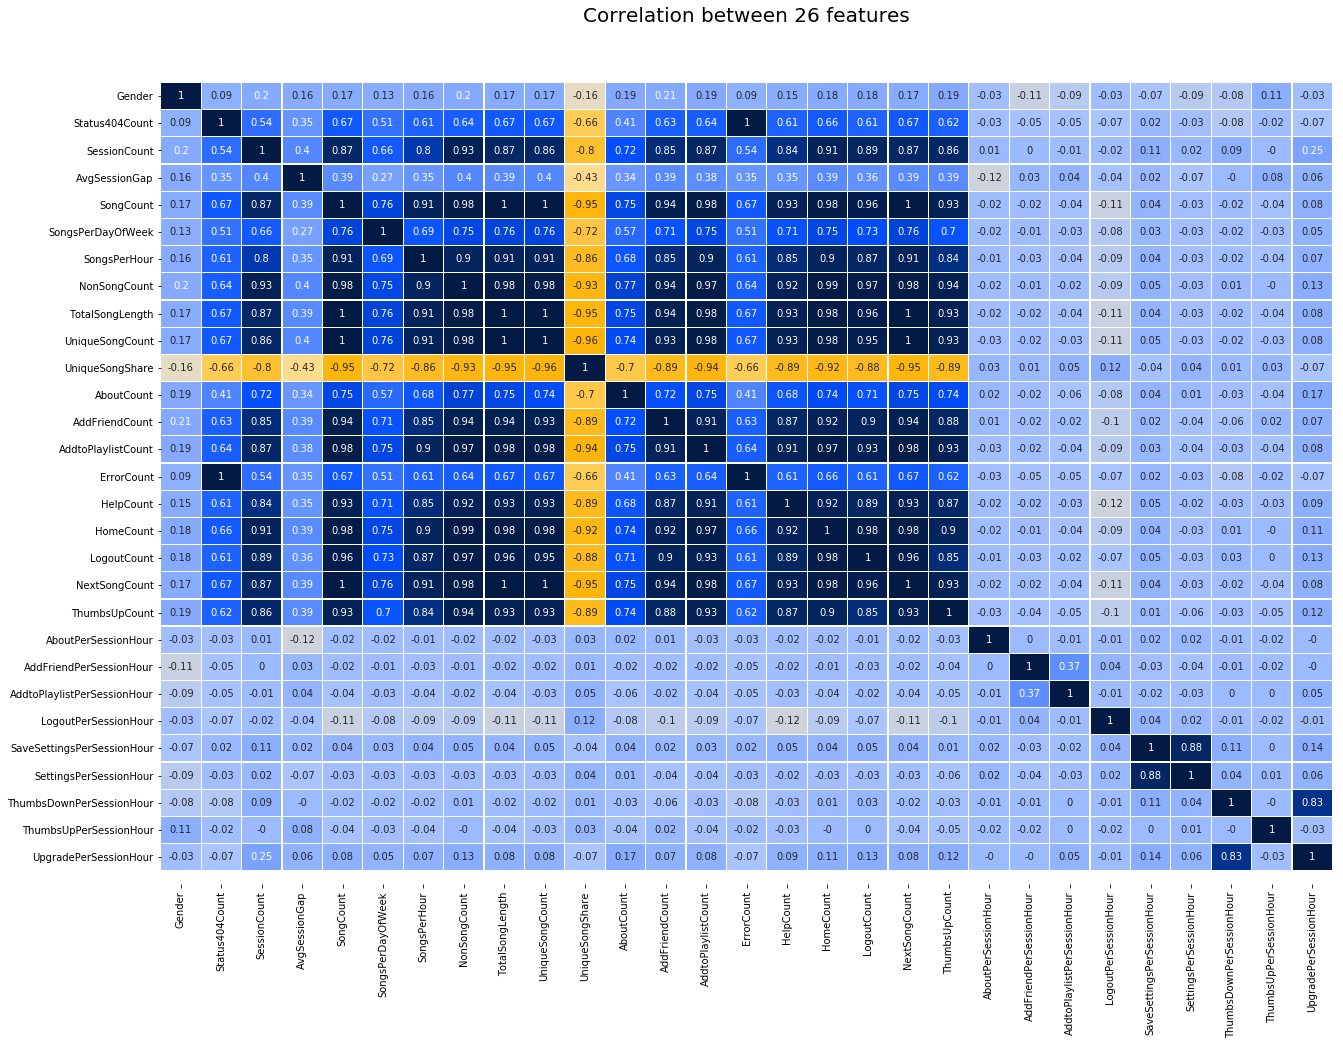

In [137]:
corr_df = data_features.toPandas()

# Plot correlation heatmap
plt.figure(figsize = [21, 15])
plt.title('Correlation between 32 features', y=1.05, size=20)
ax = sb.heatmap(corr_df.iloc[:, 1:].corr().round(2), annot=True, 
                square=False,
                cbar=False, linewidth=0.2,
                cmap = sparkify_cmap,
                vmin = -1, vmax = 1)
plt.yticks(rotation = 0)

# Correct plot cut off (Note: we must fix it due to the bug in the matplotlib 3.1.1)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [138]:
# Make a list of correlation coefficient means (absolute values) in the order of weaker to stronger correlation

corr = corr_df.iloc[:, 1:].corr()
corr.apply(lambda x : np.mean(abs(x))).sort_values()

AboutPerSessionHour            0.056279
ThumbsUpPerSessionHour         0.060931
AddFriendPerSessionHour        0.071263
AddtoPlaylistPerSessionHour    0.078390
ThumbsDownPerSessionHour       0.092936
SettingsPerSessionHour         0.097132
LogoutPerSessionHour           0.097894
SaveSettingsPerSessionHour     0.104899
UpgradePerSessionHour          0.138262
Gender                         0.167178
AvgSessionGap                  0.288403
ErrorCount                     0.437464
Status404Count                 0.437464
SongsPerDayOfWeek              0.464916
AboutCount                     0.468328
SessionCount                   0.545833
SongsPerHour                   0.546766
HelpCount                      0.558495
AddFriendCount                 0.565419
ThumbsUpCount                  0.565558
UniqueSongShare                0.570024
LogoutCount                    0.570875
AddtoPlaylistCount             0.585649
HomeCount                      0.587627
NonSongCount                   0.591378


The strong relationships in the heatmap can now be seen more clearly. We can detect variables that are strongly correlated by observing these zones, and these variables will be deselected from our list of selected features. This finding is also supported by the upper list of variables, which is arranged by correlation coefficient mean:

* SaveSettingsPerSessionHour (strongly correlated to SettingsPerSessionHour)
* Status404Count (strongly correlated to ErrorCount)
* NextSongCount (strongly correlated to SongCount)
* UniqueSongCount (strongly correlated to TotalSongLength)

I'd like to make a comment here. Because of the nature of the data, some variables have a strong correlation. However, because of the high level of correlation in some cases, we should keep them in our model. Because of the large number of features, I prefer to remove them and then plot the correlation heatmap again before continuing.

As a result, we will remove four features from the model's 32 features.

### 5.2.3. Third Correlation Analysis

In [139]:
# Model's data (28 features)
data_features = data_labels.join(f_GenderCount, 'userId', 'outer') \
    .join(f_SessionCount, 'userId', 'outer') \
    .join(f_AvgSessionGap, 'userId', 'outer') \
    .join(f_SongCount, 'userId', 'outer') \
    .join(f_SongCountPerDayOfWeek, 'userId', 'outer') \
    .join(f_SongCountPerHourOfDay, 'userId', 'outer') \
    .join(f_NonSongCount, 'userId', 'outer') \
    .join(f_TotalSongLength, 'userId', 'outer') \
    .join(f_UniqueSongShare, 'userId', 'outer') \
    .join(f_AboutCount, 'userId', 'outer') \
    .join(f_AddFriendCount, 'userId', 'outer') \
    .join(f_AddToPlaylistCount, 'userId', 'outer') \
    .join(f_ErrorCount, 'userId', 'outer') \
    .join(f_HelpCount, 'userId', 'outer') \
    .join(f_HomeCount, 'userId', 'outer') \
    .join(f_LogoutCount, 'userId', 'outer') \
    .join(f_ThumbsUpCount, 'userId', 'outer') \
    .join(f_AboutPerSessionHour, 'userId', 'outer') \
    .join(f_AddFriendPerSessionHour, 'userId', 'outer') \
    .join(f_AddToPlaylistPerSessionHour, 'userId', 'outer') \
    .join(f_LogoutPerSessionHour, 'userId', 'outer') \
    .join(f_SettingsPerSessionHour, 'userId', 'outer') \
    .join(f_ThumbsDownPerSessionHour, 'userId', 'outer') \
    .join(f_ThumbsUpPerSessionHour, 'userId', 'outer') \
    .join(f_UpgradePerSessionHour, 'userId', 'outer') \
    .drop('userId') \
    .fillna(0)

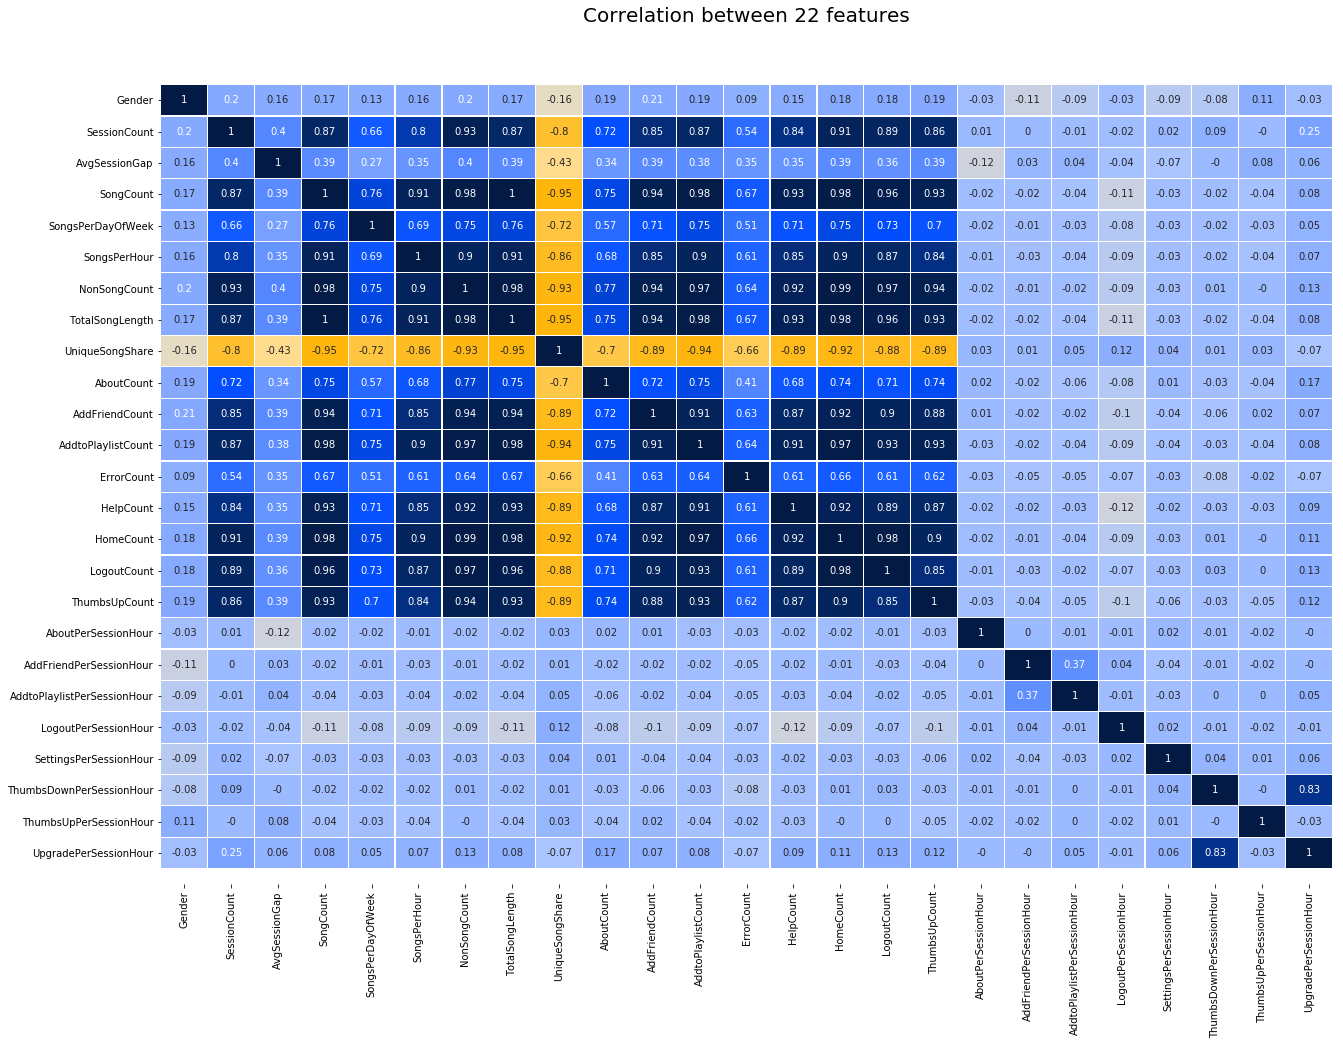

In [140]:
corr_df = data_features.toPandas()

# Plot correlation heatmap
plt.figure(figsize = [21, 15])
plt.title('Correlation between 28 features', y=1.05, size=20)
ax = sb.heatmap(corr_df.iloc[:, 1:].corr().round(2), annot=True, 
                square=False,
                cbar=False, linewidth=0.2,
                cmap = sparkify_cmap,
                vmin = -1, vmax = 1)
plt.yticks(rotation = 0)

# Correct plot cut off (Note: we must fix it due to the bug in the matplotlib 3.1.1)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [141]:
# Make a list of correlation coefficient means (absolute values) in the order of weaker to stronger correlation

corr = corr_df.iloc[:, 1:].corr()
corr.apply(lambda x : np.mean(abs(x))).sort_values()

AboutPerSessionHour            0.061275
ThumbsUpPerSessionHour         0.066682
SettingsPerSessionHour         0.073977
AddFriendPerSessionHour        0.077744
AddtoPlaylistPerSessionHour    0.085493
ThumbsDownPerSessionHour       0.098777
LogoutPerSessionHour           0.100510
UpgradePerSessionHour          0.145563
Gender                         0.173538
AvgSessionGap                  0.288054
ErrorCount                     0.413233
SongsPerDayOfWeek              0.457243
AboutCount                     0.465743
SongsPerHour                   0.535660
SessionCount                   0.537527
HelpCount                      0.546909
AddFriendCount                 0.555221
UniqueSongShare                0.556538
ThumbsUpCount                  0.556725
LogoutCount                    0.559546
AddtoPlaylistCount             0.574211
HomeCount                      0.575093
NonSongCount                   0.579921
TotalSongLength                0.581297
SongCount                      0.581314


They are natural, despite some strong correlations between other variables. For example, if someone logs in more (home page count), it's only natural that she or he logs out more (logout page count). 

I'm curious to see how our model will react to these features.

## 5.3. Testing ML Models

In [142]:
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, \
    NaiveBayes, DecisionTreeClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
import time

In [4]:
def get_features(data):
    """
    Description: 
        Extract features from model data.
    
    Args:
        data (DataFrame): the model data, which includes features and labels.
        
    Returns:
        list: a list of feature columns.
    """
    
    return data.drop('label').columns

def split_data(data, seed=0):
    """
    Description:
        Data is divided into training and testing/validation subsets. 
        I use a fixed split ratio of 80:20.
    
    Args:
        data (DataFrame): the model data with features.
        seed (int): a seed value of the random number generator.
        
    Returns:
        train (DataFrame): the training subset.
        test (DataFrame): the testing subset.
    """
    
    train, test = data.randomSplit([0.8, 0.2], seed=seed);
    return train, test

def create_pipeline(data, classifier, scaler):
    """
    Description: 
        Build a ML pipeline with the specified features, scaler, and classifier.
    
    Args:
        data (DataFrame): the model data with features.
        classifier: a machine learning classifier.

    Returns:
        pipeline (Pipeline): the pipeline.
    """
    
    features = get_features(data)
    assembler = VectorAssembler(inputCols=features, outputCol='NumFeatures')
    pipeline = Pipeline(stages=[assembler, scaler, classifier]);

    return pipeline

In [144]:
def fit_model(data, classifier, seed=0):
    """
    Description:
        Fits the machine learning model and computes metrics.
    
    Args:
        data (DataFrame): the model data with features.
        classifier: a machine learning classifier. 
        seed (int): a seed value of the random number generator.
        
    Returns:
        model: the fitted model.
        metrics: the fitted model's metrics.
    """
    
    start_time = time.time()
    
    print('Model fitting started. Please wait...')

    # Split data into train and test subset
    train, test = split_data(data, seed)
    print('Train|Test data split done.')

    # Create pipeline
    scaler = StandardScaler(inputCol='NumFeatures', outputCol='features')
    pipeline = create_pipeline(data, classifier, scaler)
    print('Create pipeline done.')

    # Train model
    model = pipeline.fit(train)
    print('Training done.')

    # Get metrics
    metrics = calc_metrics(model, test)
    print('Metrics prepared.')

    fitting_duration = time.time() - start_time
    
    print(f'Model fitting done ({int(fitting_duration)} s).')
    
    return model, metrics

In [145]:
# Source: 
#   https://stackoverflow.com/questions/60772315/how-to-evaluate-a-classifier-with-apache-spark-2-4-5-and-pyspark-python
def calc_metrics(model, test):
    """
    Description:
        The metrics of the specified model are computed.
    
    Args:
        model: the fitted model.
        test: the testing/validation subset.
        
    Returns:
        metrics: the fitted model's metrics.
    """
    
    # Create evaluators
    evaluatorMulti = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')
    evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='prediction', metricName='areaUnderROC')

    # Make predicitons
    prediction = model.transform(test).select('label', 'prediction')

    # Get metrics
    acc = evaluatorMulti.evaluate(prediction, {evaluatorMulti.metricName: 'accuracy'})
    f1 = evaluatorMulti.evaluate(prediction, {evaluatorMulti.metricName: 'f1'})
    weightedPrecision = evaluatorMulti.evaluate(prediction, {evaluatorMulti.metricName: 'weightedPrecision'})
    weightedRecall = evaluatorMulti.evaluate(prediction, {evaluatorMulti.metricName: 'weightedRecall'})
    auc = evaluator.evaluate(prediction)
    
    metrics = pd.DataFrame(index=['F1', 'accuracy', 'weighted precision', 'weighted recall', 'AUC'], \
                           data={'metrics value': [f1, acc, weightedPrecision, weightedRecall, auc]})
    
    return metrics

In [146]:
# Plot feature importances
def plot_feature_importance(data, model, height, title):
    """
    Description:
        Plots the importance of ML model features.
    
    Args:
        data (DataFrame): the model data.
        model: the fitted model.
        height (int): the plot's figure height.
        title (str): the plot's title.
    
    Returns:
        None
    """
    
    features = get_features(data)
    feature_coeff = model.stages[-1].featureImportances
    feature_importances = pd.DataFrame(list(zip(features, feature_coeff)), \
                                       columns=['Feature', 'FeatureImportances']) \
        .sort_values('FeatureImportances', ascending=False)

    values = feature_importances.sort_values(by='FeatureImportances', ascending=False)['FeatureImportances']
    labels = feature_importances.sort_values(by='FeatureImportances', ascending=False)['Feature']

    plt.figure(figsize = [8, height])
    plt.barh(np.arange(len(values)), values, height=0.6)
    ax = plt.gca()
    ax.set_yticks(np.arange(len(labels)))
    ax.set_yticklabels(labels)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('FeatureImportances')
    ax.set_ylabel('Features')
    ax.set_title(title)
    plt.grid(True, axis='x', linewidth= 1, linestyle="--")

    plt.show()

In [147]:
def fit_model_cv(data, classifier, paramGrid, numFolds=2):
    """
    Description:
        Fits the cross-validation model for tuning hyperparameters.
    
    Args:
        data (DataFrame): the model data.
        classifier: a machine learning classifier. 
        paramGrid: a ParamGridBuilder object with hyperparameters.
        numFolds: the number of folds in the cross-validation tuning.
    
    Returns:
        model_cv: the cross-validation model.
        scores_cv: the cross-validation scores.
    """
    
    start_time = time.time()
    
    print('Cross validation started. Please wait...')
    
    # Split data into train and test subset
    train, test = split_data(data)
    print('Train|Test data split done.')
    
    # Create pipeline
    scaler = StandardScaler(inputCol='NumFeatures', outputCol='features')
    pipeline = create_pipeline(data, classifier, scaler)
    print('Create pipeline done.')
    
    # Create cross validator
    crossValidator = CrossValidator(estimator = pipeline,
                              estimatorParamMaps = paramGrid,
                              evaluator = MulticlassClassificationEvaluator(),
                              numFolds = numFolds)

    # Fit cross validator
    model_cv = crossValidator.fit(train)
    
    duration = time.time() - start_time   
    print(f'Cross validation done ({int(duration)} s).')

    # Get CV scores
    scores_cv = get_cv_scores(model_cv)
    
    return model_cv, scores_cv

def get_cv_scores(model_cv):
    """Extracts the scores from the cross-validation model's metrics.
    
    Args:
        model_cv: The cross-validation model.
        
    Returns:
        params_df (pandas DataFrame): The dataframe with scores.
    """
    scores = model_cv.avgMetrics
    params = [{p.name: v for p, v in m.items()} for m in model_cv.getEstimatorParamMaps()]
    params_df = pd.DataFrame(params)
    params_df['score'] = scores
    
    return params_df.sort_values(by='score', ascending=False)

### 5.3.1. Gradient Boost Tree
> - *28 features*
> - *GBTClassifier*
> - *default hyperparameters*

In [64]:
# Fit model
classifier = GBTClassifier()
model_gbt, metrics_gbt = fit_model(data_features, classifier)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.
Training done.
Metrics prepared.
Model fitting done (2136 s).


In [65]:
# Show metrics
metrics_gbt

,metrics value
F1,0.999800
accuracy,0.999800
weighted precision,0.999801
weighted recall,0.999800
AUC,0.999875


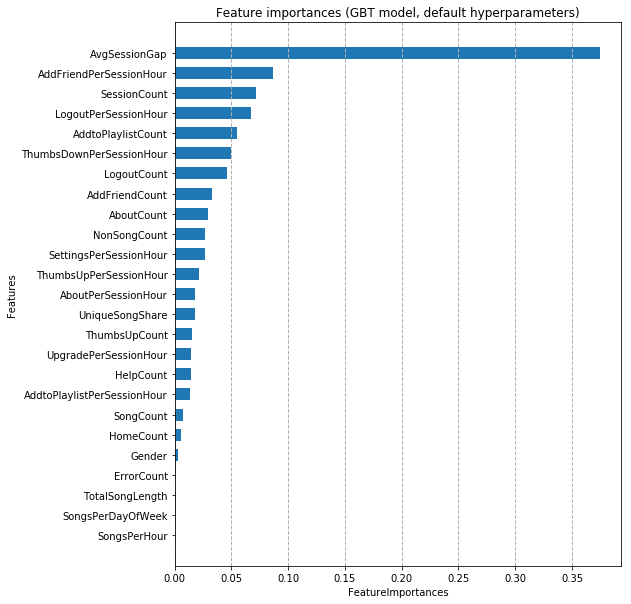

In [66]:
# Plot feature importances
plot_feature_importance(data_features, model_gbt, 10, 'Feature importances (GBT model, default hyperparameters)')

### 5.3.2. Logistic Regression
> - *28 features*
> - *LogisticRegression*
> - *default hyperparameters*

In [107]:
# Fit model
classifier = LogisticRegression(featuresCol="features", labelCol="label")
model_lr, metrics_lr = fit_model(data_features, classifier)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.
Training done.
Metrics prepared.
Model fitting done (1908 s).


In [108]:
# Show metrics
metrics_lr

,metrics value
F1,0.931169
accuracy,0.932708
weighted precision,0.931146
weighted recall,0.932708
AUC,0.874983


### 5.3.3. Random Forest
> - *28 features*
> - *RandomForestClassifier*
> - *default hyperparameters*

In [109]:
# Fit model
classifier = RandomForestClassifier(seed=42)
model_rf, metrics_rf = fit_model(data_features, classifier)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.
Training done.
Metrics prepared.
Model fitting done (1808 s).


In [110]:
# Show metrics
metrics_rf

,metrics value
F1,0.978807
accuracy,0.979233
weighted precision,0.979761
weighted recall,0.979233
AUC,0.948869


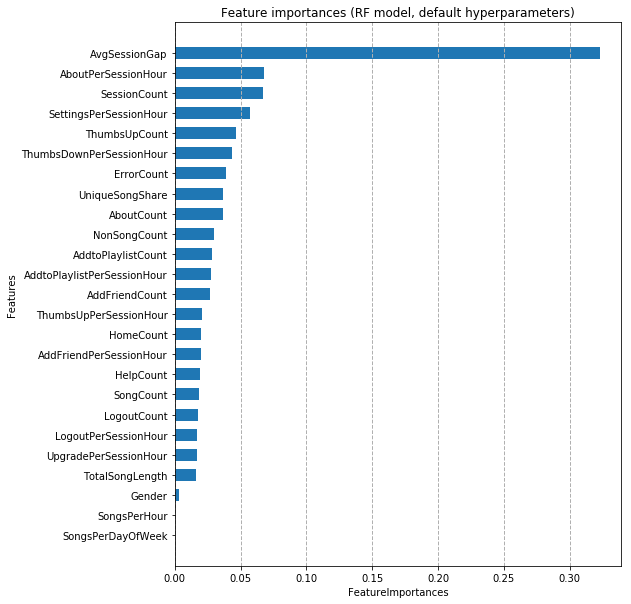

In [111]:
# Plot feature importances
plot_feature_importance(data_features, model_rf, 10, 'Feature importances (RF model, default hyperparameters)')

## 5.4. Best ML Model Optimization

### 5.4.1. Grid Search and Cross Validation with the best model

We will now perform parameter optimization using GridSearch and Cross Validation.

**Gradient Boost Tree**

> - *28 features*
> - *GBTClassifier*
> - *GridSearch*
> - *Cross Validation*

In [63]:
# Create classifier
classifier = GBTClassifier()

# Define params grid
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(classifier.maxIter, [10, 20]) \
    .addGrid(classifier.maxDepth,[2, 5]) \
    .addGrid(classifier.maxBins, [32]) \
    .build()

# Fit cross-validation model
model_gbt_cv, scores_gbt_cv = fit_model_cv(data_features, classifier, paramGrid_gbt)

Cross validation started. Please wait...
Train|Test data split done.
Create pipeline done.
Cross validation done (4815 s).


In [64]:
# Show scores
scores_gbt_cv

,maxBins,maxDepth,maxIter,score
3,32,5,20,0.999646
1,32,5,10,0.998119
2,32,2,20,0.940396
0,32,2,10,0.936061


#### 5.4.1.1. Fit Best Model with Best Params

In [62]:
# Create classifier
classifier = GBTClassifier(maxIter=20, maxDepth=5, maxBins=32)
model_gbt_cvbest, metrics_gbt_cvbest = fit_model(data_features, classifier)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.
Training done.
Metrics prepared.
Model fitting done (2191 s).


In [63]:
# Show metrics
metrics_gbt_cvbest

,metrics value
F1,0.999800
accuracy,0.999800
weighted precision,0.999801
weighted recall,0.999800
AUC,0.999875


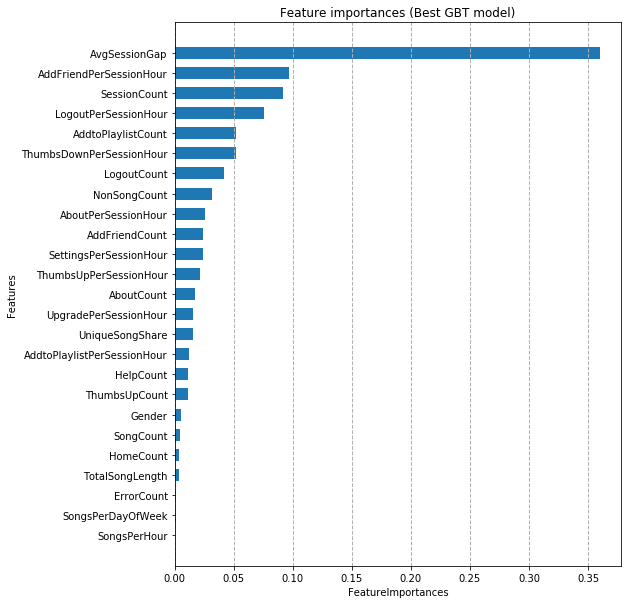

In [64]:
# Plot feature importances
plot_feature_importance(data_features, model_gbt_cvbest, 10, 'Feature importances (Best GBT model)')

### 5.4.2. Save Model

In [ ]:
model_gbt_cvbest.save("model_gbt_best")

In [75]:
from pyspark.ml import PipelineModel

# Load the saved model to see if everything is working properly
model_gbt_best = PipelineModel.load("model_gbt_best")

In [76]:
start_time = time.time()
    
print('Model test started. Please wait...')

# Split data into train and test subset
train, test = split_data(data_features, seed=0)
print('Train|Test data split done.')

# Obtain metrics
metrics = calc_metrics(model_gbt_best, test)
print('Metrics prepared.\n')

metrics

Model test started. Please wait...
Train|Test data split done.
Metrics prepared.



,metrics value
F1,0.999800
accuracy,0.999800
weighted precision,0.999801
weighted recall,0.999800
AUC,0.999875


## 5.5. Summary 

The initial full feature set was selected based on the general statistical method results and the previously defined delta threshold. Correlation tests between the selected features revealed that some of them had a significant relationship. As a result, some of the features from our initial set were removed.

I have tested three well-known ML models, which are: Random Forest, Gradient Boost Tree, and Logistic Regression with the same features selected after the correlation analysis (28). After that I selected the model which achieved better results considering the metrics assessed (_F1 = 0.9998_), and tried to optimize the already excellent results trough gridsearch and cross-validation. The best model was Gradient Boost Tree and the best hyperparameters were:

* maxIter=20 
* maxDepth=5
* maxBins=32

The following were the model's five most important features:

* AvgSessionGap (~35%)
* AddFriendPerSessionHour (~10%)
* SessionCount (~9%)
* LogoutPerSessionHour (~7%)
* AddToPlaylistCount (~5%)
* ThumbsDownPerSessionHour (~5%)

Given the business context and the results presented in the EDA section, we can conclude (given our model's excellent results) that what most contributes to predicting a churning user is:

* **shorter time of inactivity between sessions**
* **fewer friend additions per session hour (i.e. less friends added)**
* **fewer sessions**
* **more logouts per session hour**
* **fewer songs were added to their playlists**
* **more interactions with thumbs down (i.e. dislike more frequently the songs played)**

### 5.5.1. Remark about sample dataset

Our sample dataset represents only 1/100 of the data in the original dataset, which is a very small portion. Models with a small amount of data are more likely to have a higher variance and, as a result, are more prone to overfitting. Because the model fitting is so sensitive to even minor changes in random data split. If we get good results, it doesn't mean we'll get the same results with other splits. Depending on the training/test dataset, the results of the ML models can differ significantly. Perhaps one of the other two models tested here can lead to better results in the original dataset.

Altough the results obtained in the sample dataset were excellent and I am pleased with the model selected, we have to move to the cluster, repeat the exploratory data analysis there, adjust the feature engineering, exercise and tune the model accordingly using the full dataset in order to confirm (or reject) our results achieved here by the sample dataset.

**Because I do not have credits to use the AWS EMR, I will consider this project completed. The code in this notebook is easily adaptable to work in an AWS notebook using PySpark Kernel.**

**Big dataset**
> - size: **12GB**
> - row count: **26,259,199**
> - user count: **22,278**:
>  - *5,003 cancelled users*
>  - *5,103 downgraded users*
> - data source: **s3n://udacity-dsnd/sparkify/sparkify_event_data.json**
> - can be executed on: **Amazon EMR cluster**

### Workspace Specs

In [2]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2299.998
cache size	: 46080 KB
physical id	: 0
siblings	: 1
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single pti ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4599.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

